<h1>Reti neurali per la regressione dei parametri della star-formation rate density</h1>
<h2>Tecniche di Rappresentazione e Modellizzaione dei Dati - Lorenzo Avanzini</h2>

### Abstract

La star-formation rate density (SFRD), ovvero il tasso di formazione stellare per unità di
volume, è una quantità che dipende, oltre che dall'età dell'Universo a cui la si misura
(ovvero il redshift), dal modello cosmologico ed astrofisico:

\begin{equation*}
    SFRD = f(z,\vec{\theta})
\end{equation*}

dove $\vec{\theta}$ è il vettore dei parametri cosmologici ed astrofisici da cui dipende la grandezza.
Dunque dalla misura della SFRD a diversi redshift è possibile, in linea di principio,
ricavare i parametri cosmologici ed astrofisici da cui dipende. Data la difficoltà a derivare un modello analitico per tale dipendenza, lo scopo di questo progetto sarà quello di approssimare con una rete neuronale la funzione inversa 

\begin{equation*}
    \vec{\theta} = f^{-1}(z,SFRD(z))
\end{equation*}

Per raggiungere tale obiettivo, ci è fornito un dataset composto da 1000 record: ogni record è composto da 100 elementi, rappresentanti un campionamento della SFRD per valori di redshift equispaziati tra 0 e 7, e da 6 elementi rappresentanti i valori dei parametri

\begin{equation*}
    \vec{\theta} = (\Omega_m, \sigma_8, A_{SN1}, A_{SN2}, A_{AGN1}, A_{AGN2})
\end{equation*}



## Indice

1. Gestione del dataset e pre-elaborazione
2. Creazione ed addestramento di una rete
3. Ottimizzazione degli iperparametri ed addestramento della rete ottimizzata
4. Analisi delle previsioni del modello ottimizzato
5. Addestramento di un modello ottimizzato per la stima dei parametri ed errori associati
6. Effetto del data leakage nella standardizzazione/normalizzazione del dataset
7. Conclusioni

### 1. Gestione del dataset e pre-elaborazione

Dopo aver importato le librerie necessarie, selezioneremo il dispositivo su cui svolgere i conti. In questo caso, non essendo CUDA disponibile, sono stati fatti su CPU. In seguito, caricheremo i record del dataset da file tramite numpy.

In [2]:
#importo le librerie necessarie
import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch.nn as nn, scipy.stats as stats, torch, time, optuna, getdist
from getdist import plots, MCSamples
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

%matplotlib inline
#plt.rcdefaults()
rng = np.random.default_rng( seed = 1 )

/home/lorenzo/anaconda3/envs/Sviluppo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#seleziono il device su cui svolgere i calcoli
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


In [4]:
#carico il dataset di output
params = np.loadtxt('params.txt')

In [5]:
#carico il dataset di input
sfrh = np.load('sfrh.npy')

Per familiarizzare con il dataset, plottiamo cinque campioni della SFRD in funzione del redshift.

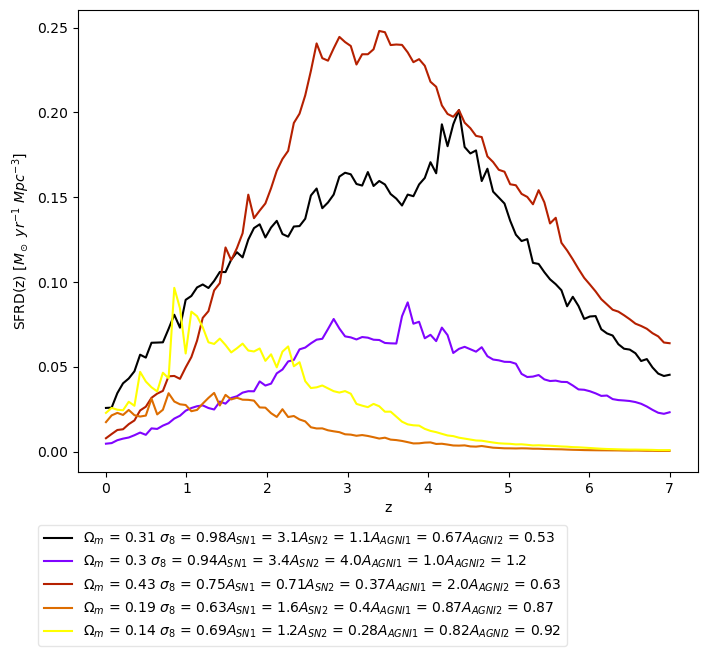

In [7]:
#faccio il grafico dei primi 5 record del dataset di input
z = np.linspace(0.0, 7.0, 100)


cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, 5)]
nomi = ['$\Omega_m$',' $\sigma_8$', '$A_{SN1}$', '$A_{SN2}$', '$A_{AGNI1}$', '$A_{AGNI2}$']

plt.figure(figsize = (8, 6))
for i in range(5):
    b=f''
    for j, n in enumerate(nomi):
        b = b+f'{n} = {params[i,j]:0.2}'
    plt.plot(z, sfrh[i], c = colors[i], label = b)

leg = plt.legend(bbox_to_anchor = (0.8,-0.1))
leg.get_frame().set_alpha(0.5)
plt.xlabel('z')
plt.ylabel('SFRD(z) [$M_\odot \ yr^{-1} \ Mpc^{-3}$]')
plt.show()

A questo punto, definiamo le classi che ci serviranno alla gestione e alla pre-elaborazione del dataset. La classe `dataset` è una classe ausiliaria, minimale, che permette la gestione delle più basiche operazioni che si possano fare con un dataset: nell'inizializzazione, carica valori di input e output e comprende i metodi standard che permettono di accedere alle informazioni del dataset. Più sofisticata è la classe `make_dataset`. Questa viene inizializzata caricando i record di input e output del dataset assieme alla dimensione dei batch di addestramento che verranno utilizzati e al seed che garantisce la riproducibilità delle operazioni casuali. Il metodo `split` consente di suddividere il dataset in tre sottoinsiemi (training, validation e test), di dimensioni specificate dall'utente: viene generato un array di indici che saranno mescolati in maniera casuale; dopo aver calcolato gli indici che rappresentano la fine dei tre sottoinsiemi, vengono estratti gli indici relativi ai tre dataset, permettendo di suddividere il dataset originale. Il metodo calcola poi media, varianza, minimo e massimo del dataset di training, valori necessari al funzionamento dei metodi `std`, `norm`, `destd`, `denorm`, `array_std`, `array_denorm`. Questi permettono di standardizzare e normalizzare i sottoinsiemi del dataset, ed in generale quasiasi vettore, nella scala definita dal dataset di training: questa scelta è stata fatta per evitare di introdurre dell'informazione facente parte del dataset di test nei dataset di training e di validation (a partire dalla standardizzazione o della normalizzazione). Il metodo `create_loader` serve a raccogliere i set di training, validation e test per ritornare dei data loader costruiti su di essi.

In [6]:
class dataset: #creo la classe dataset, utile dopo
    def __init__(self, x, y): #classe minimale: input e output
        self.input, self.output, self.size = x, y, x.shape[0]
        
    def __len__(self): #metodi standard per l'accesso alle informazioni del dataset
        return self.size

    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

class make_dataset: #creo la classe principale per la gestione dei dati
    def __init__(self, x, y, batch_size, seed): #richiedo input, output, grandezza dei batch e seed
        self.input, self.output = x, y
        self.batch_size = batch_size
        self.seed = seed
        self.n_train = self.input.shape[0] #ricavo il numero di esempi di addestramento presenti

    def split(self, perc_train = 0.7, perc_valid = 0.15): #questo metodo permette di splittare il dataset grezzo im train, validation e test
        self.perc_train, self.perc_valid = perc_train, perc_valid
        np.random.seed(self.seed) #seed fissato per la riproducibilità
        indexes = np.arange(self.n_train) #creo la lista degli indici
        np.random.shuffle(indexes) #mescolo la lista degli indici in modo casuale

        self.train_end = int(self.n_train*self.perc_train) #calcolo gli indici di fine training dataset e di fine validation dataset
        self.valid_end = int(self.n_train*(self.perc_train+self.perc_valid))

        train_indexes = indexes[:self.train_end] #estraggo il dataset di test
        valid_indexes = indexes[self.train_end:self.valid_end] #estraggo il dataset di validation
        test_indexes = indexes[self.valid_end:] #estraggo il dataset di test
        

        self.train_input  = torch.tensor(self.input[train_indexes], dtype=torch.float32) #memorizzo l'input train dataset nella classe
        self.train_output = torch.tensor(self.output[train_indexes], dtype=torch.float32) #analogamente per l'output train dataset
        

        self.input_mean = self.train_input.mean(axis = 0) #calcolo media, varianza, minimo e massimo di input e output nel train set
        self.input_std = self.train_input.std(axis = 0)
        
        self.output_mean = self.train_output.mean(axis = 0) 
        self.output_std = self.train_output.std(axis = 0)
        
        self.input_MIN = self.train_input.min(dim = 0)[0] #.min(dim=0) restituisce il vettore di minimi per ogni colonna e il vettore di
        self.input_MAX = self.train_input.max(dim = 0)[0] #indici. con [0] selezioniamo il vettore di minimi (come torch tensor)
        
        self.output_MIN = self.train_output.min(dim = 0)[0]
        self.output_MAX = self.train_output.max(dim = 0)[0]

        
        self.valid_input  = torch.tensor(self.input[valid_indexes], dtype=torch.float32) #memorizzo l'input validation dataset nella classe
        self.valid_output = torch.tensor(self.output[valid_indexes], dtype=torch.float32) #analogamente per l'output del validation dataset
        
        self.test_input  = torch.tensor(self.input[test_indexes], dtype=torch.float32) #memorizzo l'input del test dataset nella classe
        self.test_output = torch.tensor(self.output[test_indexes], dtype=torch.float32) #analogamente per l'output del test dataset
        

    def std(self, io): #metodo di standardizzazione dei dataset rispetto al train dataset
        if io == 'input':
            self.train_input = (self.train_input-self.input_mean)/self.input_std
            self.valid_input = (self.valid_input-self.input_mean)/self.input_std
            self.test_input = (self.test_input-self.input_mean)/self.input_std
        elif io == 'output':
            self.train_output = (self.train_output-self.output_mean)/self.output_std
            self.valid_output = (self.valid_output-self.output_mean)/self.output_std
            self.test_output = (self.test_output-self.output_mean)/self.output_std
            
    def norm(self, io): #metodo di normalizazzione dei dataset rispetto al train dataset
        if io == 'input':
            self.train_input = (self.train_input-self.input_MIN)/(self.input_MAX-self.input_MIN)
            self.valid_input = (self.valid_input-self.input_MIN)/(self.input_MAX-self.input_MIN)
            self.test_input = (self.test_input-self.input_MIN)/(self.input_MAX-self.input_MIN)
        elif io == 'output':
            self.train_output = (self.train_output-self.output_MIN)/(self.output_MAX-self.output_MIN)
            self.valid_output = (self.valid_output-self.output_MIN)/(self.output_MAX-self.output_MIN)
            self.test_output = (self.test_output-self.output_MIN)/(self.output_MAX-self.output_MIN)

    def destd(self, io): #metodo di destandardizzazione dei dataset rispetto al train dataset
        if io == 'input':
            self.train_input = self.train_input*self.input_std+self.input_mean
            self.valid_input = self.valid_input*self.input_std+self.input_mean
            self.test_input = self.test_input*self.input_std+self.input_mean
        elif io == 'output':
            self.train_output = self.train_output*self.output_std+self.output_mean
            self.valid_output = self.valid_output*self.output_std+self.output_mean
            self.test_output = self.test_output*self.output_std+self.output_mean
            
    def denorm(self, io): #metodo di denormalizzazione dei dataset rispetto al train dataset
        if io == 'input':
            self.train_input = self.train_input*(self.input_MAX-self.input_MIN)+self.input_MIN
            self.valid_input = self.valid_input*(self.input_MAX-self.input_MIN)+self.input_MIN
            self.test_input = self.test_input*(self.input_MAX-self.input_MIN)+self.input_MIN
        elif io == 'output':
            self.train_output = self.train_output*(self.output_MAX-self.output_MIN)+self.output_MIN
            self.valid_output = self.valid_output*(self.output_MAX-self.output_MIN)+self.output_MIN
            self.test_output = self.test_output*(self.output_MAX-self.output_MIN)+self.output_MIN

    def array_std(self, io, vec): #metodo di standardizzazione di un vettore qualunque rispetto al train_dataset
        if io == 'input':
            vec = (vec-self.input_mean)/self.input_std
        elif io == 'output':
            vec = (vec-self.output_mean)/self.output_std
        return vec
        
    def array_norm(self, io, vec): #metodo di normalizzazione di un vettore qualunque rispetto al train dataset
        if io == 'input':
            vec = (vec-self.input_MIN)/(self.input_MAX-self.input_MIN)
        elif io == 'output':
            vec = (vec-self.output_MIN)/(self.output_MAX-self.output_MIN)
        return vec
        
    def array_destd(self, io, vec): #metodo di destandardizzazione di un vettore qualunque rispetto al train dataset
        if io == 'input':
            vec = vec*self.input_std+self.input_mean
        elif io == 'output':
            vec = vec*self.output_std+self.output_mean
        return vec
            
    def array_denorm(self, io, vec): #metodo di denormalizzazione di un vettore qualunque rispetto al train dataset
        if io == 'input':
            vec = vec*(self.input_MAX-self.input_MIN)+self.input_MIN
        elif io == 'output':
            vec = vec*(self.output_MAX-self.output_MIN)+self.output_MIN
        return vec    
        
    def create_loader(self): #metodo per la creazione dei data loader
        self.train_data = dataset(self.train_input, self.train_output) #¢reazione di oggetti dataset per il passaggio a dataloader
        self.valid_data = dataset(self.valid_input, self.valid_output)
        self.test_data = dataset(self.test_input, self.test_output)

        #creazione dei dataloader
        train_loader = DataLoader(dataset = self.train_data, batch_size = self.batch_size, shuffle = True)
        valid_loader = DataLoader(dataset = self.valid_data, batch_size = self.batch_size, shuffle = True)
        test_loader = DataLoader(dataset = self.test_data, batch_size = self.batch_size, shuffle = True)

        return train_loader, valid_loader, test_loader
        

Prepariamo gli elementi della rete che rimarranno costanti (numero di input, numero di output, ...) e applichiamo le pre-elaborazioni al dataset, standardizzandone gli input, normalizzandone gli output e generando i data loader. Queste pre-elaborazioni sono utili ad evitare problemi di stabilità numerica, dovuti a valori eccessivamente grandi, e a impedire che le feature con input su scale superiori oscurino le feature con input che operano a scale minori.

In [7]:
#definizione degli elementi di architettura base della rete
seed = 1
Nin = 100
Nout = 6
batch_size = 32
f_model = 'best_model.pt'
prune = True

#manipolazione dei dati
DATA = make_dataset(sfrh, params, batch_size, seed) #caricamento di input e output nella classe
DATA.split() #split del dataset in train set, validation set e test set
DATA.std('input') #standardizzazione degli input
DATA.norm('output') #normalizzione degli output
train_loader, valid_loader, test_loader = DATA.create_loader() #creazione dei data loader

### 2. Creazione ed addestramento di una rete

La funzione `network_init` rende possibile una creazione rapida di un modello a rete neurale, riportando il numero di input richiesti, il numero di output attesi, una lista con il numero di neuroni per layer nascosti ed una lista con le attivazioni da utilizzare alla fine di ogni strato di parametri. Essendo questo un problema a regressione, la funzione di attivazione dopo lo strato di output sarà l'identità. Per gli altri strati, utilizzeremo l'attivazione `nn.LeakyReLU` con iperparametro `leak` che determineremo. La funzione `network_train` permette di addestrare i modelli creati con `network_init`. Per farlo, è necessario passare alla funzione il modello da allenare e una serie di parametri utili all'addestramento. In particolare: il learning rate `lr` ed il weight decay `wd` che servono all'`optimizer` (in questo caso Adam) per la discesa del gradiente; ci sono poi i parametri usati dallo `scheduler`, ovvero il fattore di decrescita `factor` da applicare al learning rate se non migliora per un numero di epoche stabilito (`patience`, anch'esso passato alla funzione), il learning rate minimo oltre al quale non applicare tale fattore (`min_lr`), il numero di epoche di addestramento `epoch` e `stop_criterion` che rappresenta il numero di epoche dopo le quali applicare un "early stopping" nel caso il modello non sia migliorato (nel senso di aver trovato un nuovo minimo per la funzione di loss del validation set); infine, la funzione di loss `loss_func`, `min_valid_loss_param` (un parametro ausiliario che indica quanto debba essere piccola la funzione di loss per poter permettere di considerare il modello "migliorato" alle prime epoche, tipicamente scelto grande), i loader di addestramento e validazione `train_loader` e `valid_loader` su cui calcolare le loss, il file `f_model` in cui salvare il modello, `verbose` che se impostato a `True` fa scrivere a schermo lo stato di addestramento nel tempo, `trial` e `prune` utili all'utilizzo della libreria `optuna`, che tratteremo dopo, e `mean_loss`, anch'esso parametro booleano che tratteremo tra poco. La routine di addestramento segue il seguente flow dove ad ogni epoca:
* si estraggono i batch di addestramento dal train loader;
* si calcola l'output del modello sull'input preso dal data loader;
* si valuta il contributo del batch alla loss;
* finito il ciclo sui batch, si calcolano i gradienti con la backpropagation e si aggiornano i pesi;
* si ripete il processo senza allenare il modello ma calcolando la loss sui batch del validation set;
* se richiesto, si chiama il trial di optuna;
* se ci sono le condizioni, si chiama l'early stopping, il report di optuna o il salvataggio del modello.

La loss che useremo sarà la Mean Square Error:

\begin{equation*}
    \mathcal{L} = \sum_i (y_i-\hat{y}_i)^2
\end{equation*}

dove $y_i$ sono i valori attesi dei parametri e $\hat{y}_i$ sono le previsioni fatte dal modello.

In [8]:
def network_init(n_in, n_out, hidden_layers, activations): #n_in e n_out int, hidden_layers int list, n activations = n hidden+1
    n_hidden = len(hidden_layers) #identifico il numero di strati nascosti
                  
    if n_hidden == 0: #se non ci sono strati nascosti
        if activations == None: #e non ci sono attivazioni
            model = nn.Linear(n_in, n_out) #ritorno un modello lineare composto dai soli neuroni di input e di output (uno strato)
        else: #se invece è presente un'attivazione per lo strato di output
            if type(activations) == list: #se l'attivazione è data come lista, ne estraggo l'unica componente (la prima)
                activations = activations[0]
            model = nn.Sequential(nn.Linear(n_in, n_out), activations) #creo un modello come quello sopra con attivazione finale
            
    else: #in presenza di strati nascosti
        layers = [nn.Linear(n_in, hidden_layers[0]), activations[0]] #creo lo strato tra l'input e il primo layer nascosto, con attivazione
        for i in range(n_hidden-1): #il numero di strati di pesi è pari al numero di strati nascosti+1 (uno è per quello di input)
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1])) #aggiungo uno strato di pesi tra i prossimi due layer nascosti
            if activations != None and activations != []: #se sono segnalate attivazioni
                layers.append(activations[i+1]) #aggiungo la prossima attivazione segnalata per questo strato
        layers.append(nn.Linear(hidden_layers[n_hidden-1], n_out)) #creo lo strato di pesi tra l'ultimo layer nascosto e l'output
        if activations != None and activations != []: #se sono segnalate attivazioni
            layers.append(activations[n_hidden]) #aggiungo un'eventuale attivazione sullo strato di output
        model = nn.Sequential(*layers) #metto assieme il modello

    return model #ritorno il modello

def network_train(model, lr, wd, factor, patience, min_lr, epochs, stop_criterion, 
                  loss_func, min_valid_loss_param, train_loader, valid_loader, f_model, 
                  verbose = True, trial = None, prune = True, mean_loss = True):
    
    #¢reo un optimizer per minimizzare la loss ed uno scheduler per diminuire il learning_rate al diminuire della loss    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, betas = (0.9, 0.999), weight_decay = wd)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = factor, patience = patience, min_lr = min_lr)

    start = time.time() #calcolo l'istante di tempo di inizio del training
    train_value = np.zeros(epochs) #preparo i vettori per salvare le loss per epoca
    valid_value = np.zeros(epochs)
    min_valid_loss = min_valid_loss_param
    epoch_best_model = 0
    
    for epoch in range(epochs): #per ogni epoca
        train_loss, points = 0.0, 0 #azzero la loss e il numero di punti dei batch "visitati"; prepariamo la fase di training
        model.train()
        
        for x_train, y_train in train_loader: #estraiamo un input ed un output dal data loader
            #individuo la dimenzione del batch di input
            bs = x_train.shape[0]

            if mean_loss == True: #nel caso della MSE servirà moltiplicare le loss per il numero di esempi nel batch per poi riscalarla
                coeff = bs #ed ottenere la MSE sul totale dei punti nei batch
            else:
                coeff = 1 #nel caso della loss con varianze, tale operazione non sarà necessaria

            #individuo input e output del batch assieme alla previsione della rete
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred  = model(x_train)

            #calcolo la loss sul batch Lj = (1/nj sum_i (y_ij-yhat_ij)^2)
            loss = loss_func(y_pred, y_train)
            
            train_loss += (loss.item())*coeff #moltiplico per nj per ottenere la somma degli scarti quadratici e aggiorno la loss
            points     += bs                      #solo se la loss è media: altrimenti non serve moltiplicare.
            #aggiorno il numero di punti visitati

            #azzero i gradienti residui, calcolo i gradienti ed eseguo il passo di epoca
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #calcolo la loss totale come la somma degli scarti quadratici totale divisa il numero di punti analizzati
        train_loss /= points
        train_value[epoch] = train_loss
    
        valid_loss, points = 0.0, 0 #analogamente a prima; ci poniamo nella modalità di validazione del modello
        model.eval()

        #ripeto quanto sopra senza aggiornare i parametri del modello
        for x_val, y_val in valid_loader:
            with torch.no_grad():
                bs = x_val.shape[0]

                if mean_loss == True: #nel caso della MSE servirà moltiplicare le loss per il numero di esempi nel batch per poi riscalarla
                    coeff = bs #ed ottenere la MSE sul totale dei punti nei batch
                else:
                    coeff = 1 #nel caso della loss con varianze, tale operazione non sarà necessaria
    
                y_val = y_val.to(device)
                x_val = x_val.to(device)
                y_pred = model(x_val)
    
                valid_loss += (loss_func(y_pred, y_val).item())*coeff
                points     += bs
    
        valid_loss /= points
        valid_value[epoch] = valid_loss
        #chiamo lo scheduler per gestire il learning rate
        scheduler.step(valid_loss) 

        #se richiesto, chiamo il report dei trial per optuna
        if trial is not None:
            trial.report(valid_loss, epoch)
            if trial.should_prune():
                if prune == True:
                    raise optuna.exceptions.TrialPruned()
                else:
                    pass
    
        if verbose == True:
            print(f'epoch:{epoch}, valid loss: {valid_loss:.4f}', end = '')
        #salvo il modello solo se la nuova loss ha raggiunto il valore minimo (che in quel caso aggiorno)
        if valid_loss < min_valid_loss:
            torch.save(model.state_dict(), f_model)
            min_valid_loss = valid_loss
            epoch_best_model = epoch
            if verbose == True:
                print(' (best-model), epoch: ', epoch, ', max epoch: ', epochs)
        else:
            if verbose == True:
                print('')

        #se non si vedono miglioramenti nel minimo della loss per un numero definito di epoche, si pratica l'early stopping
        if epoch - epoch_best_model > stop_criterion:
            if verbose == True:
                print ('Training stop at epoch:', epoch, ' because the best model does not imporved after ', stop_criterion, ' epochs')
            break
    
    end = time.time() #ritorno il tempo di addestramento
    if verbose == True:
        print('Time taken (seconds):', "{:.4f}".format(end-start), "=")

    return train_value, valid_value, epoch_best_model, min_valid_loss

def objective(trial):
    global Nin, Nout, train_loader, valid_loader, f_model, prune

    #esploriamo lo spazio degli iperparametri: learning rate, numero di strati nascosti e di neuroni per strato, il leak della LeakyReLU
    lr = trial.suggest_float('learning_rate', 1e-6, 1e-3, log = True)
    n_hidden = trial.suggest_int('n_hidden', 1, 5)
    hidden_layers = [trial.suggest_int(f'hidden_{i+1}', 1, 100, log = True) for i in range(n_hidden)]
    leak = trial.suggest_float('leak', -1, 1)

    #preparo le attivazioni
    activations = []
    for i in range(n_hidden):
        activation = nn.LeakyReLU(leak)
        activations.append(activation)
    activations.append(nn.Identity())

    epochs = 100 #100
    wd = 1e-4
    factor = 0.3
    patience = 40
    min_lr = 0.1e-6
    stop_criterion = 60
    loss_func = nn.MSELoss()
    min_valid_loss_param = 1e100

    #creo un modello e lo addestro
    model = network_init(n_in = Nin, n_out = Nout, hidden_layers = hidden_layers, activations = activations)
    train_value, valid_value, epoch_best_model, min_valid_loss = network_train(model, lr, wd, factor, patience, 
                                                                               min_lr, epochs, stop_criterion,
                                                                               loss_func, min_valid_loss_param,
                                                                               train_loader, valid_loader, f_model, 
                                                                               verbose = False, trial = trial, prune = prune)

    return min_valid_loss #ritorno il minimo valore assunto dalla loss di validazione durante l'addestramento

Facciamo partire l'addestramento di qualche rete di test con architettura casuale e valutiamone le prestazioni.

In [181]:
wd = 1e-4
factor = 0.25
patience = 50
min_lr = 1e-8
stop_criterion = 50
loss_func = nn.MSELoss()
min_valid_loss_param = 1e100

hidden_layers1 = []
hidden_layers2 = [50]
hidden_layers3 = [10,10,10]
hidden_layers4 = [1000,500,500,100]

activations1 = None
activations2 = [nn.ReLU(), nn.Identity()]
activations3 = [nn.LeakyReLU(0.1), nn.ReLU(), nn.ReLU(), nn.Identity()]
activations4 = [nn.ReLU(), nn.LeakyReLU(0.1), nn.ReLU(), nn.LeakyReLU(-0.1), nn.Identity()]

lr1 = 1
lr2 = 1e-2
lr3 = 1e-6
lr4 = 5e-4

epochs1 = 200
epochs2 = 50
epochs3 = 500
epochs4 = 250

f_model1 = 'beta_model1.pt'
f_model2 = 'beta_model2.pt'
f_model3 = 'beta_model3.pt'
f_model4 = 'beta_model4.pt'

model1 = network_init(n_in = Nin, n_out = Nout, hidden_layers = hidden_layers1, activations = activations1)
model2 = network_init(n_in = Nin, n_out = Nout, hidden_layers = hidden_layers2, activations = activations2)
model3 = network_init(n_in = Nin, n_out = Nout, hidden_layers = hidden_layers3, activations = activations3)
model4 = network_init(n_in = Nin, n_out = Nout, hidden_layers = hidden_layers4, activations = activations4)

train_value1, valid_value1, epoch_best_model1, min_valid_loss1 = network_train(model1, lr1, wd, factor, patience, 
                                                                           min_lr, epochs1, stop_criterion,
                                                                           loss_func, min_valid_loss_param,
                                                                           train_loader, valid_loader, f_model1, verbose = True)
train_value2, valid_value2, epoch_best_model2, min_valid_loss2 = network_train(model2, lr2, wd, factor, patience, 
                                                                           min_lr, epochs2, stop_criterion,
                                                                           loss_func, min_valid_loss_param,
                                                                           train_loader, valid_loader, f_model2, verbose = True)
train_value3, valid_value3, epoch_best_model3, min_valid_loss3 = network_train(model3, lr3, wd, factor, patience, 
                                                                           min_lr, epochs3, stop_criterion,
                                                                           loss_func, min_valid_loss_param,
                                                                           train_loader, valid_loader, f_model3, verbose = True)
train_value4, valid_value4, epoch_best_model4, min_valid_loss4 = network_train(model4, lr4, wd, factor, patience, 
                                                                           min_lr, epochs4, stop_criterion,
                                                                           loss_func, min_valid_loss_param,
                                                                           train_loader, valid_loader, f_model4, verbose = True)

epoch:0, valid loss: 1012.5667 (best-model), epoch:  0 , max epoch:  200
epoch:1, valid loss: 341.3965 (best-model), epoch:  1 , max epoch:  200
epoch:2, valid loss: 96.7568 (best-model), epoch:  2 , max epoch:  200
epoch:3, valid loss: 47.3352 (best-model), epoch:  3 , max epoch:  200
epoch:4, valid loss: 36.5931 (best-model), epoch:  4 , max epoch:  200
epoch:5, valid loss: 15.5448 (best-model), epoch:  5 , max epoch:  200
epoch:6, valid loss: 3.1731 (best-model), epoch:  6 , max epoch:  200
epoch:7, valid loss: 1.2501 (best-model), epoch:  7 , max epoch:  200
epoch:8, valid loss: 1.2767
epoch:9, valid loss: 0.5374 (best-model), epoch:  9 , max epoch:  200
epoch:10, valid loss: 0.8148
epoch:11, valid loss: 0.2981 (best-model), epoch:  11 , max epoch:  200
epoch:12, valid loss: 0.3705
epoch:13, valid loss: 0.2627 (best-model), epoch:  13 , max epoch:  200
epoch:14, valid loss: 0.2594 (best-model), epoch:  14 , max epoch:  200
epoch:15, valid loss: 0.2078 (best-model), epoch:  15 , max

Possiamo poi valutare le prestazioni di questi modelli plottando le loss functions di train e di validation.

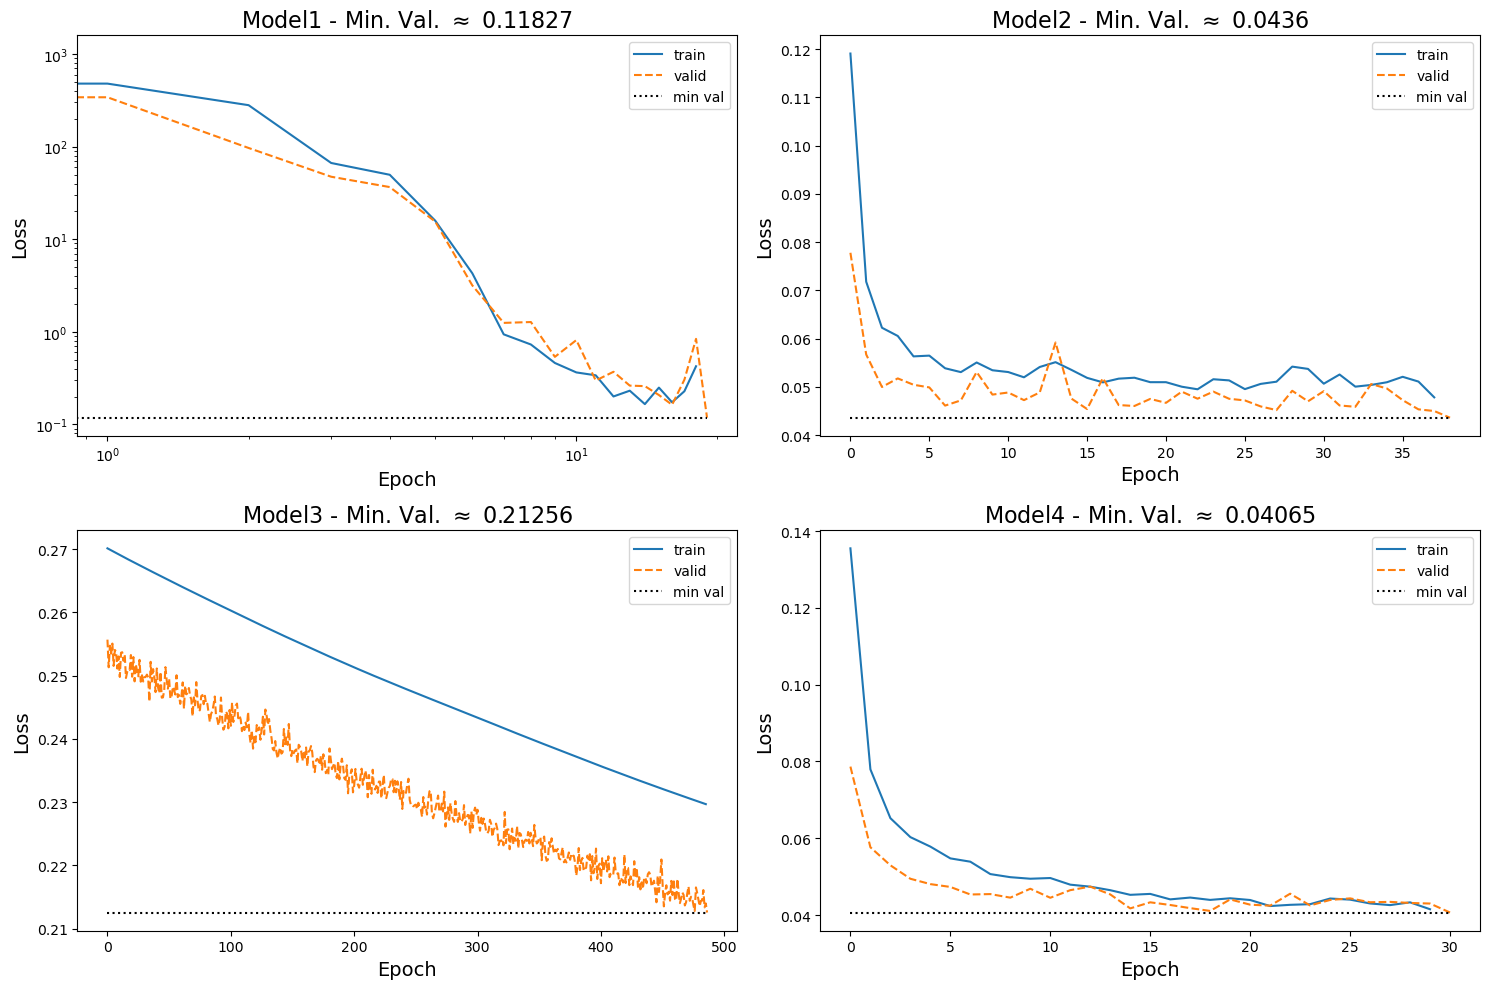

In [195]:
#grafichiamo la training loss e la validation loss
fig, ax = plt.subplots(2, 2, figsize = (15, 10))

epoche_train1 = np.arange(epoch_best_model1)
epoche_valid1 = np.arange(epoch_best_model1+1)
mvl1 = float(min_valid_loss1)*np.ones_like(epoche_valid1)

epoche_train2 = np.arange(epoch_best_model2)
epoche_valid2 = np.arange(epoch_best_model2+1)
mvl2 = float(min_valid_loss2)*np.ones_like(epoche_valid2)

epoche_train3 = np.arange(epoch_best_model3)
epoche_valid3 = np.arange(epoch_best_model3+1)
mvl3 = float(min_valid_loss3)*np.ones_like(epoche_valid3)

epoche_train4 = np.arange(epoch_best_model4)
epoche_valid4 = np.arange(epoch_best_model4+1)
mvl4 = float(min_valid_loss4)*np.ones_like(epoche_valid4)

ax[0, 0].plot(epoche_train1, train_value1[:epoch_best_model1], label = 'train')
ax[0, 0].plot(epoche_valid1, valid_value1[:epoch_best_model1+1], ls = '--', label = 'valid')
ax[0, 0].plot(epoche_valid1, mvl1, label = 'min val', ls = ':', color = 'k')
ax[0, 0].set_xlabel("Epoch", fontsize = 14)
ax[0, 0].set_ylabel('Loss', fontsize = 14)
ax[0, 0].set_title(f'Model1 - Min. Val. $\\approx$ {round(min_valid_loss1, 5)}', fontsize = 16)
ax[0, 0].loglog()
ax[0, 0].legend()

ax[0, 1].plot(epoche_train2, train_value2[:epoch_best_model2], label = 'train')
ax[0, 1].plot(epoche_valid2, valid_value2[:epoch_best_model2+1], ls = '--', label = 'valid')
ax[0, 1].plot(epoche_valid2, mvl2, label = 'min val', ls = ':', color = 'k')
ax[0, 1].set_xlabel("Epoch", fontsize = 14)
ax[0, 1].set_ylabel('Loss', fontsize = 14)
ax[0, 1].set_title(f'Model2 - Min. Val. $\\approx$ {round(min_valid_loss2, 5)}', fontsize = 16)
ax[0, 1].legend()

ax[1, 0].plot(epoche_train3, train_value3[:epoch_best_model3], label = 'train')
ax[1, 0].plot(epoche_valid3, valid_value3[:epoch_best_model3+1], ls = '--', label = 'valid')
ax[1, 0].plot(epoche_valid3, mvl3, label = 'min val', ls = ':', color = 'k')
ax[1, 0].set_xlabel("Epoch", fontsize = 14)
ax[1, 0].set_ylabel('Loss', fontsize = 14)
ax[1, 0].set_title(f'Model3 - Min. Val. $\\approx$ {round(min_valid_loss3, 5)}', fontsize = 16)
ax[1, 0].legend()

ax[1, 1].plot(epoche_train4, train_value4[:epoch_best_model4], label = 'train')
ax[1, 1].plot(epoche_valid4, valid_value4[:epoch_best_model4+1], ls = '--', label = 'valid')
ax[1, 1].plot(epoche_valid4, mvl4, label = 'min val', ls = ':', color = 'k')
ax[1, 1].set_xlabel("Epoch", fontsize = 14)
ax[1, 1].set_ylabel('Loss', fontsize = 14)
ax[1, 1].set_title(f'Model4 - Min. Val. $\\approx$ {round(min_valid_loss4, 5)}', fontsize = 16)
ax[1, 1].legend()
plt.tight_layout()
plt.show()

Notiamo subito come il valore di loss più alto sia dato dal terzo modello e come questo non abbia evidentemente raggiunto la convergenza. Il primo modello raggiunge un valore di loss inferiore al terzo ma dello stesso ordine di grandezza, superiore ai modelli restanti. Il secondo e il quarto modello raggiungono valori di loss molto simili e sembrano mostrare una buona convergenza che non presenti overfitting. Torneremo sulla somiglianza delle loss di questi modelli più avanti. Ma come ottimizzare gli iperparametri senza cercare $completamente$ a caso? 

### 3. Ottimizzazione degli iperparametri ed addestramento della rete ottimizzata

La libreria `optuna` ci permette di eseguire una ricerca nello spazio degli iperparametri, campionando le prestazioni di modelli dall'architettura differente su brevi addestramenti che individuino quale struttura possa rivelarsi la più promettente su addestramenti più lunghi. Lo scopo è quello di minimizzare la funzione `objective` dove facciamo proporre alcuni iperparametri ad `optuna` e una volta creato ed addestrato un modello con tali iperparametri, ne valutiamo le prestazioni considerando il valore minimo assunto dalla validation loss function. L'opzione di pruning ci permette di scartare dopo poche epoche i modelli che hanno performato sensibilmente meno degli altri candidati al processo di selezione.

In [8]:
#eseguiamo l'ottimizzazione degli iperparametri tramite il "campionamento" delle prestazioni nello spazio degli iperparametri
study = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(), pruner = optuna.pruners.PercentilePruner(80.0))
study.optimize(objective, n_trials = 50, show_progress_bar = True)#50

[I 2025-12-09 04:16:51,649] A new study created in memory with name: no-name-2a5b446c-e048-4322-9051-bfb8023302d1
Best trial: 0. Best value: 0.0457179:   2%|▏         | 1/50 [00:06<05:10,  6.33s/it]

[I 2025-12-09 04:16:57,989] Trial 0 finished with value: 0.04571787854035696 and parameters: {'learning_rate': 0.0009206698825028265, 'n_hidden': 1, 'hidden_1': 84, 'leak': 0.5284948100964655}. Best is trial 0 with value: 0.04571787854035696.


Best trial: 0. Best value: 0.0457179:   4%|▍         | 2/50 [00:09<03:28,  4.34s/it]

[I 2025-12-09 04:17:00,929] Trial 1 finished with value: 0.15286335349082947 and parameters: {'learning_rate': 3.5509577854205807e-06, 'n_hidden': 2, 'hidden_1': 12, 'hidden_2': 61, 'leak': -0.9946882369972538}. Best is trial 0 with value: 0.04571787854035696.


Best trial: 0. Best value: 0.0457179:   6%|▌         | 3/50 [00:12<03:09,  4.03s/it]

[I 2025-12-09 04:17:04,607] Trial 2 finished with value: 0.054810823500156404 and parameters: {'learning_rate': 0.00046784916039669186, 'n_hidden': 5, 'hidden_1': 3, 'hidden_2': 2, 'hidden_3': 4, 'hidden_4': 75, 'hidden_5': 8, 'leak': -0.7034397478112924}. Best is trial 0 with value: 0.04571787854035696.


Best trial: 0. Best value: 0.0457179:   8%|▊         | 4/50 [00:21<04:24,  5.74s/it]

[I 2025-12-09 04:17:12,956] Trial 3 finished with value: 0.19350149432818095 and parameters: {'learning_rate': 2.279070735827576e-05, 'n_hidden': 5, 'hidden_1': 42, 'hidden_2': 40, 'hidden_3': 12, 'hidden_4': 1, 'hidden_5': 2, 'leak': 0.1576904119992435}. Best is trial 0 with value: 0.04571787854035696.


Best trial: 0. Best value: 0.0457179:  12%|█▏        | 6/50 [00:25<03:39,  4.99s/it]

[I 2025-12-09 04:17:16,629] Trial 4 finished with value: 0.05604779342810313 and parameters: {'learning_rate': 0.0004047625692506502, 'n_hidden': 5, 'hidden_1': 9, 'hidden_2': 27, 'hidden_3': 2, 'hidden_4': 3, 'hidden_5': 4, 'leak': 0.8430664283845395}. Best is trial 0 with value: 0.04571787854035696.
[I 2025-12-09 04:17:16,673] Trial 5 pruned. 
[I 2025-12-09 04:17:16,715] Trial 6 pruned. 


Best trial: 0. Best value: 0.0457179:  20%|██        | 10/50 [00:25<00:51,  1.29s/it]

[I 2025-12-09 04:17:16,838] Trial 7 pruned. 
[I 2025-12-09 04:17:16,902] Trial 8 pruned. 
[I 2025-12-09 04:17:16,957] Trial 9 pruned. 


Best trial: 0. Best value: 0.0457179:  22%|██▏       | 11/50 [00:30<01:25,  2.18s/it]

[I 2025-12-09 04:17:22,546] Trial 10 finished with value: 0.04967073102792104 and parameters: {'learning_rate': 9.236449835541974e-05, 'n_hidden': 1, 'hidden_1': 80, 'leak': 0.8064494047728535}. Best is trial 0 with value: 0.04571787854035696.


Best trial: 0. Best value: 0.0457179:  24%|██▍       | 12/50 [00:35<01:45,  2.77s/it]

[I 2025-12-09 04:17:27,282] Trial 11 finished with value: 0.04770719587802887 and parameters: {'learning_rate': 0.0001395081496483619, 'n_hidden': 1, 'hidden_1': 95, 'leak': 0.7883755777192065}. Best is trial 0 with value: 0.04571787854035696.


Best trial: 0. Best value: 0.0457179:  26%|██▌       | 13/50 [00:41<02:07,  3.46s/it]

[I 2025-12-09 04:17:32,853] Trial 12 finished with value: 0.04726627429326375 and parameters: {'learning_rate': 0.00013338116471472338, 'n_hidden': 2, 'hidden_1': 90, 'hidden_2': 8, 'leak': 0.590827792983577}. Best is trial 0 with value: 0.04571787854035696.


Best trial: 13. Best value: 0.0430487:  28%|██▊       | 14/50 [00:45<02:14,  3.75s/it]

[I 2025-12-09 04:17:37,442] Trial 13 finished with value: 0.04304866760969162 and parameters: {'learning_rate': 0.0009407798929472623, 'n_hidden': 2, 'hidden_1': 46, 'hidden_2': 9, 'leak': 0.4714937854474634}. Best is trial 13 with value: 0.04304866760969162.


Best trial: 13. Best value: 0.0430487:  30%|███       | 15/50 [00:51<02:29,  4.28s/it]

[I 2025-12-09 04:17:43,133] Trial 14 finished with value: 0.04321938385566076 and parameters: {'learning_rate': 0.0008519683548985236, 'n_hidden': 2, 'hidden_1': 40, 'hidden_2': 9, 'leak': 0.4455092726159076}. Best is trial 13 with value: 0.04304866760969162.


Best trial: 13. Best value: 0.0430487:  34%|███▍      | 17/50 [00:57<01:53,  3.44s/it]

[I 2025-12-09 04:17:49,121] Trial 15 finished with value: 0.0430987216035525 and parameters: {'learning_rate': 0.0009675785932778602, 'n_hidden': 2, 'hidden_1': 32, 'hidden_2': 9, 'leak': 0.10400301129781303}. Best is trial 13 with value: 0.04304866760969162.
[I 2025-12-09 04:17:49,268] Trial 16 pruned. 


Best trial: 13. Best value: 0.0430487:  36%|███▌      | 18/50 [01:01<01:50,  3.46s/it]

[I 2025-12-09 04:17:52,759] Trial 17 finished with value: 0.04788925180832545 and parameters: {'learning_rate': 0.0002904771551662512, 'n_hidden': 3, 'hidden_1': 35, 'hidden_2': 5, 'hidden_3': 12, 'leak': -0.3346004097030865}. Best is trial 13 with value: 0.04304866760969162.


Best trial: 13. Best value: 0.0430487:  42%|████▏     | 21/50 [01:01<00:40,  1.40s/it]

[I 2025-12-09 04:17:52,984] Trial 18 pruned. 
[I 2025-12-09 04:17:53,046] Trial 19 pruned. 
[I 2025-12-09 04:17:53,132] Trial 20 pruned. 


Best trial: 13. Best value: 0.0430487:  44%|████▍     | 22/50 [01:04<00:49,  1.76s/it]

[I 2025-12-09 04:17:56,011] Trial 21 finished with value: 0.04403033157189687 and parameters: {'learning_rate': 0.0007215878637116906, 'n_hidden': 2, 'hidden_1': 45, 'hidden_2': 8, 'leak': 0.43085181672454254}. Best is trial 13 with value: 0.04304866760969162.


Best trial: 22. Best value: 0.0420977:  46%|████▌     | 23/50 [01:08<01:03,  2.36s/it]

[I 2025-12-09 04:18:00,066] Trial 22 finished with value: 0.04209767719109853 and parameters: {'learning_rate': 0.000491659155419169, 'n_hidden': 2, 'hidden_1': 53, 'hidden_2': 21, 'leak': 0.3133275180375563}. Best is trial 22 with value: 0.04209767719109853.


Best trial: 23. Best value: 0.0418467:  48%|████▊     | 24/50 [01:12<01:11,  2.74s/it]

[I 2025-12-09 04:18:03,842] Trial 23 finished with value: 0.04184665968020757 and parameters: {'learning_rate': 0.0004364529326618784, 'n_hidden': 3, 'hidden_1': 53, 'hidden_2': 23, 'hidden_3': 22, 'leak': 0.2889477411061516}. Best is trial 23 with value: 0.04184665968020757.


Best trial: 23. Best value: 0.0418467:  50%|█████     | 25/50 [01:16<01:21,  3.25s/it]

[I 2025-12-09 04:18:08,410] Trial 24 finished with value: 0.043783214489618937 and parameters: {'learning_rate': 0.00021928511840799695, 'n_hidden': 4, 'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 19, 'hidden_4': 83, 'leak': 0.6404488201362015}. Best is trial 23 with value: 0.04184665968020757.


Best trial: 25. Best value: 0.0414089:  52%|█████▏    | 26/50 [01:22<01:35,  3.99s/it]

[I 2025-12-09 04:18:14,289] Trial 25 finished with value: 0.04140894730885824 and parameters: {'learning_rate': 0.00041172814340154887, 'n_hidden': 3, 'hidden_1': 59, 'hidden_2': 19, 'hidden_3': 100, 'leak': 0.3267624491297389}. Best is trial 25 with value: 0.04140894730885824.


Best trial: 26. Best value: 0.0410386:  54%|█████▍    | 27/50 [01:29<01:50,  4.82s/it]

[I 2025-12-09 04:18:21,111] Trial 26 finished with value: 0.04103862702846527 and parameters: {'learning_rate': 0.0004204163559496178, 'n_hidden': 3, 'hidden_1': 63, 'hidden_2': 20, 'hidden_3': 96, 'leak': 0.30581664929480523}. Best is trial 26 with value: 0.04103862702846527.


Best trial: 26. Best value: 0.0410386:  56%|█████▌    | 28/50 [01:33<01:43,  4.68s/it]

[I 2025-12-09 04:18:25,466] Trial 27 finished with value: 0.04294741362333298 and parameters: {'learning_rate': 0.00015506531570342387, 'n_hidden': 3, 'hidden_1': 18, 'hidden_2': 44, 'hidden_3': 93, 'leak': 0.29978327335221766}. Best is trial 26 with value: 0.04103862702846527.


Best trial: 26. Best value: 0.0410386:  58%|█████▊    | 29/50 [01:37<01:34,  4.51s/it]

[I 2025-12-09 04:18:29,581] Trial 28 finished with value: 0.04224905749162038 and parameters: {'learning_rate': 0.00032751250995482876, 'n_hidden': 4, 'hidden_1': 72, 'hidden_2': 16, 'hidden_3': 32, 'hidden_4': 22, 'leak': 0.03618095616313183}. Best is trial 26 with value: 0.04103862702846527.


Best trial: 26. Best value: 0.0410386:  60%|██████    | 30/50 [01:38<01:04,  3.25s/it]

[I 2025-12-09 04:18:29,817] Trial 29 pruned. 


Best trial: 26. Best value: 0.0410386:  62%|██████▏   | 31/50 [01:43<01:13,  3.89s/it]

[I 2025-12-09 04:18:35,218] Trial 30 finished with value: 0.041285815040270485 and parameters: {'learning_rate': 0.0005140841173361584, 'n_hidden': 4, 'hidden_1': 63, 'hidden_2': 26, 'hidden_3': 27, 'hidden_4': 19, 'leak': -0.19236621069168183}. Best is trial 26 with value: 0.04103862702846527.


Best trial: 31. Best value: 0.0410267:  64%|██████▍   | 32/50 [01:49<01:20,  4.46s/it]

[I 2025-12-09 04:18:41,048] Trial 31 finished with value: 0.04102673242489497 and parameters: {'learning_rate': 0.0005307719404527686, 'n_hidden': 4, 'hidden_1': 70, 'hidden_2': 27, 'hidden_3': 23, 'hidden_4': 26, 'leak': -0.21764579234925413}. Best is trial 31 with value: 0.04102673242489497.


Best trial: 31. Best value: 0.0410267:  66%|██████▌   | 33/50 [01:53<01:13,  4.32s/it]

[I 2025-12-09 04:18:45,024] Trial 32 finished with value: 0.04116007715463638 and parameters: {'learning_rate': 0.0005942364522957449, 'n_hidden': 4, 'hidden_1': 68, 'hidden_2': 34, 'hidden_3': 34, 'hidden_4': 22, 'leak': -0.4444879125324322}. Best is trial 31 with value: 0.04102673242489497.


Best trial: 31. Best value: 0.0410267:  68%|██████▊   | 34/50 [01:59<01:15,  4.72s/it]

[I 2025-12-09 04:18:50,687] Trial 33 finished with value: 0.04150520980358124 and parameters: {'learning_rate': 0.0005811755231026166, 'n_hidden': 4, 'hidden_1': 71, 'hidden_2': 36, 'hidden_3': 29, 'hidden_4': 23, 'leak': -0.3115844581682542}. Best is trial 31 with value: 0.04102673242489497.


Best trial: 31. Best value: 0.0410267:  70%|███████   | 35/50 [01:59<00:51,  3.44s/it]

[I 2025-12-09 04:18:51,148] Trial 34 pruned. 
[I 2025-12-09 04:18:51,185] Trial 35 pruned. 


Best trial: 31. Best value: 0.0410267:  74%|███████▍  | 37/50 [02:05<00:42,  3.27s/it]

[I 2025-12-09 04:18:57,290] Trial 36 finished with value: 0.048037182291348776 and parameters: {'learning_rate': 0.0002906707643030541, 'n_hidden': 4, 'hidden_1': 27, 'hidden_2': 75, 'hidden_3': 8, 'hidden_4': 11, 'leak': -0.9273952532785823}. Best is trial 31 with value: 0.04102673242489497.


Best trial: 37. Best value: 0.0408384:  78%|███████▊  | 39/50 [02:12<00:33,  3.01s/it]

[I 2025-12-09 04:19:03,574] Trial 37 finished with value: 0.04083838115135829 and parameters: {'learning_rate': 0.0005966748857997944, 'n_hidden': 5, 'hidden_1': 9, 'hidden_2': 64, 'hidden_3': 44, 'hidden_4': 39, 'hidden_5': 51, 'leak': -0.19513681513366146}. Best is trial 37 with value: 0.04083838115135829.
[I 2025-12-09 04:19:03,727] Trial 38 pruned. 


Best trial: 37. Best value: 0.0408384:  82%|████████▏ | 41/50 [02:16<00:22,  2.52s/it]

[I 2025-12-09 04:19:08,271] Trial 39 finished with value: 0.043543418447176616 and parameters: {'learning_rate': 0.0006336072490494993, 'n_hidden': 5, 'hidden_1': 8, 'hidden_2': 35, 'hidden_3': 46, 'hidden_4': 44, 'hidden_5': 78, 'leak': -0.5042372707060139}. Best is trial 37 with value: 0.04083838115135829.
[I 2025-12-09 04:19:08,424] Trial 40 pruned. 


Best trial: 37. Best value: 0.0408384:  84%|████████▍ | 42/50 [02:19<00:21,  2.67s/it]

[I 2025-12-09 04:19:11,511] Trial 41 finished with value: 0.045335098306337994 and parameters: {'learning_rate': 0.0005344903137717894, 'n_hidden': 4, 'hidden_1': 6, 'hidden_2': 29, 'hidden_3': 27, 'hidden_4': 18, 'leak': -0.1708225346053427}. Best is trial 37 with value: 0.04083838115135829.


Best trial: 37. Best value: 0.0408384:  86%|████████▌ | 43/50 [02:20<00:13,  1.97s/it]

[I 2025-12-09 04:19:11,745] Trial 42 pruned. 


Best trial: 37. Best value: 0.0408384:  88%|████████▊ | 44/50 [02:23<00:14,  2.49s/it]

[I 2025-12-09 04:19:15,479] Trial 43 finished with value: 0.04424252907435099 and parameters: {'learning_rate': 0.0006194205956472434, 'n_hidden': 4, 'hidden_1': 38, 'hidden_2': 14, 'hidden_3': 15, 'hidden_4': 15, 'leak': -0.22921735764002574}. Best is trial 37 with value: 0.04083838115135829.


Best trial: 37. Best value: 0.0408384:  90%|█████████ | 45/50 [02:24<00:09,  1.92s/it]

[I 2025-12-09 04:19:16,023] Trial 44 pruned. 


Best trial: 37. Best value: 0.0408384:  92%|█████████▏| 46/50 [02:24<00:05,  1.41s/it]

[I 2025-12-09 04:19:16,280] Trial 45 pruned. 


Best trial: 37. Best value: 0.0408384:  94%|█████████▍| 47/50 [02:24<00:03,  1.09s/it]

[I 2025-12-09 04:19:16,567] Trial 46 pruned. 


Best trial: 37. Best value: 0.0408384: 100%|██████████| 50/50 [02:26<00:00,  2.93s/it]

[I 2025-12-09 04:19:17,809] Trial 47 pruned. 
[I 2025-12-09 04:19:17,931] Trial 48 pruned. 
[I 2025-12-09 04:19:17,971] Trial 49 pruned. 


In [19]:
#salviamo gli iperparametri ottimizzati
best_trial = study.best_trial.params
torch.save(best_trial, 'best_hyperparams.pt')
print(best_trial)

{'learning_rate': 0.0005966748857997944, 'n_hidden': 5, 'hidden_1': 9, 'hidden_2': 64, 'hidden_3': 44, 'hidden_4': 39, 'hidden_5': 51, 'leak': -0.19513681513366146}


Dopo aver condotto lo studio con `optuna`, riportiamo i risultati ottenuti. Dal grafico dei valori intermedi, possiamo vedere come la loss di validazione sia evoluta ad ogni epoca e per ogni trial di addestramento. Similmente, possiamo vedere la storia dei minimi delle loss di validazione (la funzione `objective`) nel grafico "Optimization History Plot". Il "Parallel Coordinate Plot" rappresenta gli iperparametri come coordinate verticali e i trial come linee colorate che, intersecando tali assi, individuano una combinazione di iperparametri, associandoci un valore di validation loss indicato con un color code. Il plot "Hyperparameter importances" mostra quanto peso percentuale abbiano avuto i vari iperparametri durante l'ottimizzazione.

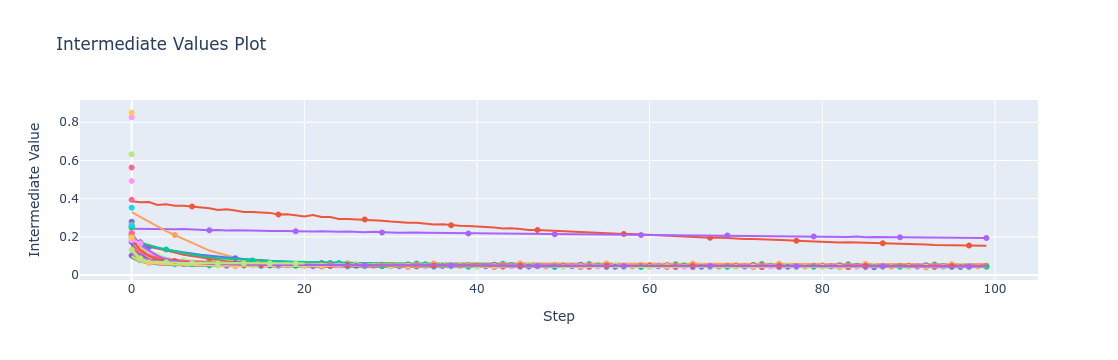

In [20]:
optuna.visualization.plot_intermediate_values(study)

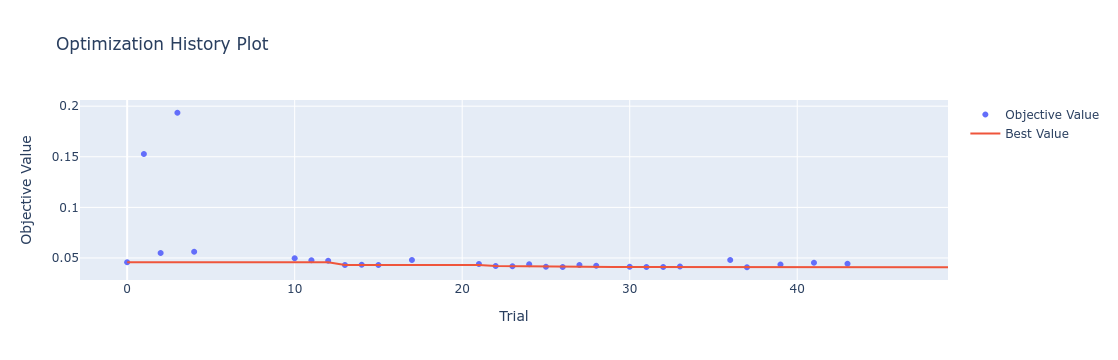

In [21]:
optuna.visualization.plot_optimization_history(study)

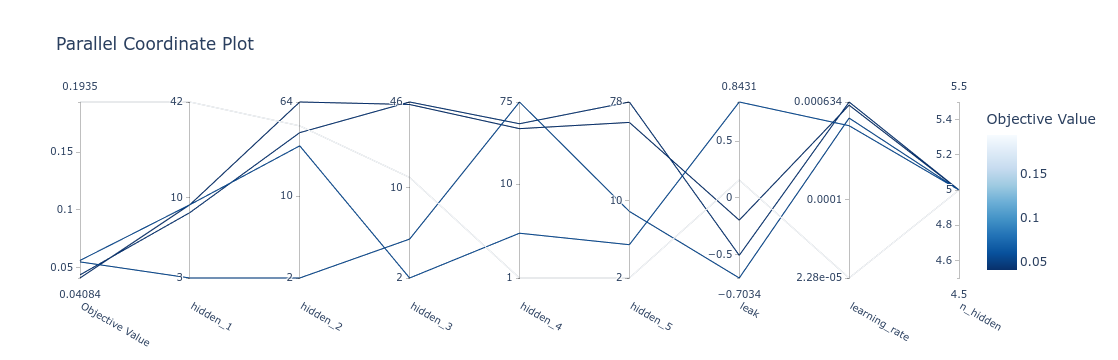

In [22]:
optuna.visualization.plot_parallel_coordinate(study)

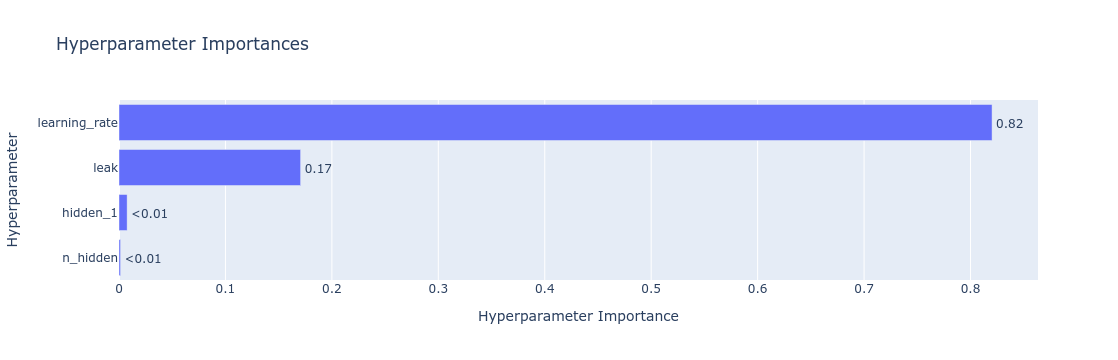

In [23]:
optuna.visualization.plot_param_importances(study)

Importando gli iperparametri ottimizzati, siamo in grado di generare un modello che addestreremo su un numero di epoche più lungo.

In [9]:
#prepariamo gli iperparametri per l'addestramento del modello
best_trial = torch.load('best_hyperparams.pt')
keys = []
hidden_layers = []
for key, value in best_trial.items():
    if 'hidden_' in key:
        keys.append(key)
sorted_keys = sorted(keys, key = lambda x: int(x.split('_')[1]))
for key in sorted_keys:
    hidden_layers.append(best_trial[key])

lr = best_trial.get('learning_rate')
leak = best_trial.get('leak')
activations = []
for i in range(len(hidden_layers)):
    activation = nn.LeakyReLU(leak)
    activations.append(activation)
activations.append(nn.Identity())

epochs = 1000 #1k
wd = 1e-4
factor = 0.25 #0.25
patience = 50 #25
min_lr = 1e-6 #1e-6
stop_criterion = 600 #600
loss_func = nn.MSELoss()
min_valid_loss_param = 1e100

In [10]:
#creiamo il modello
model = network_init(n_in = Nin, n_out = Nout, hidden_layers = hidden_layers, activations = activations)

In [26]:
#addestriamo il modello
train_value, valid_value, epoch_best_model, min_valid_loss = network_train(model, lr, wd, factor, patience, 
                                                                           min_lr, epochs, stop_criterion,
                                                                           loss_func, min_valid_loss_param,
                                                                           train_loader, valid_loader, f_model, verbose = True)

epoch:0, valid loss: 0.1620 (best-model), epoch:  0 , max epoch:  1000
epoch:1, valid loss: 0.0912 (best-model), epoch:  1 , max epoch:  1000
epoch:2, valid loss: 0.0707 (best-model), epoch:  2 , max epoch:  1000
 (best-model), epoch:  3 , max epoch:  1000
epoch:4, valid loss: 0.0602 (best-model), epoch:  4 , max epoch:  1000
epoch:5, valid loss: 0.0571 (best-model), epoch:  5 , max epoch:  1000
epoch:6, valid loss: 0.0549 (best-model), epoch:  6 , max epoch:  1000
epoch:7, valid loss: 0.0530 (best-model), epoch:  7 , max epoch:  1000
epoch:8, valid loss: 0.0525 (best-model), epoch:  8 , max epoch:  1000
epoch:9, valid loss: 0.0502 (best-model), epoch:  9 , max epoch:  1000
epoch:10, valid loss: 0.0504
epoch:11, valid loss: 0.0502
epoch:12, valid loss: 0.0492 (best-model), epoch:  12 , max epoch:  1000
epoch:13, valid loss: 0.0494
epoch:14, valid loss: 0.0491 (best-model), epoch:  14 , max epoch:  1000
epoch:15, valid loss: 0.0492
epoch:16, valid loss: 0.0497
epoch:17, valid loss: 0.04

In [27]:
#salviamo i risultati ottenuti
torch.save(train_value, 'train_value.pt')
torch.save(valid_value, 'valid_value.pt')
torch.save(epoch_best_model, 'epoch_best_model.pt')
torch.save(min_valid_loss, 'min_valid_loss.pt')
print('Minimo della validation loss: ', min_valid_loss)

Minimo della validation loss:  0.040572115878264106


Plottiamo la train loss, la validation loss e il valore minimo raggiunto dalla validation loss. Come si evince dal grafico, durante le prime epoche avviene la maggior parte della discesa della loss function che poi si assesta su un plateau. La discesa coinvolge sia la training loss che la validation loss: avendo raggiunto queste lo stesso ordine di grandezza, siamo portati a pensare che il modello abbia raggiunto una buona convergenza, evitando problemi di overfitting e underfitting. Questa conferma, ad ogni modo, potrà essere data solo dopo aver calcolato la loss function sul dataset di test e dopo aver confermato che questa non sia eccessivamente superiore alla validation loss e alla training loss.

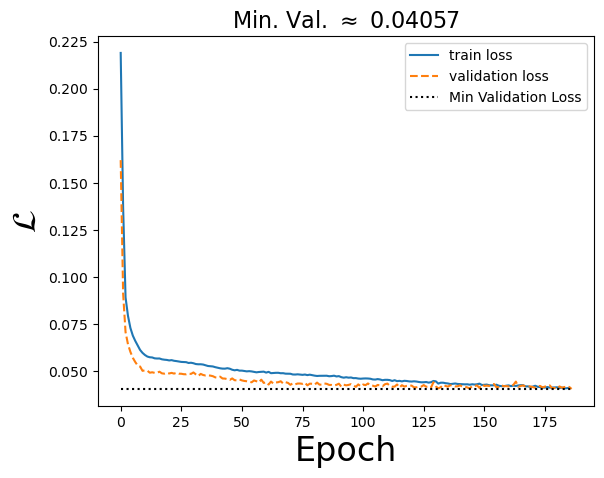

In [194]:
#grafichiamo la training loss e la validation loss
train_value = torch.load('train_value.pt', weights_only = False)
valid_value = torch.load('valid_value.pt', weights_only = False)
epoch_best_model = torch.load('epoch_best_model.pt', weights_only = False)
min_valid_loss = torch.load('min_valid_loss.pt', weights_only = False)
epoche_train = np.arange(epoch_best_model)
epoche_valid = np.arange(epoch_best_model+1)
mvl = float(min_valid_loss)*np.ones_like(epoche_valid)

plt.plot(epoche_train, train_value[:epoch_best_model], label = 'train loss')
plt.plot(epoche_valid, valid_value[:epoch_best_model+1], ls = '--', label = 'validation loss')
plt.plot(epoche_valid, mvl, label = 'Min Validation Loss', ls = ':', color = 'k')

plt.xlabel("Epoch", fontsize = 24)
plt.ylabel("$\mathcal{L}$", fontsize = 24)
plt.title(f'Min. Val. $\\approx$ {round(float(min_valid_loss), 5)}', fontsize = 16)
plt.legend()
plt.show()

Notiamo subito che il valore minimo raggiunto dalla validation loss è praticamente lo stesso (seppur leggermente minore) di quelli ottenuti dai modelli numero 2 e numero 4 dei test condotti sopra! Non è un caso: il modello non può imparare meglio di quanto i dati non gli consentano; nei dati stessi è presente una varianza dovuta all'imprecisione della loro misura, quindi, anche riducendo l'errore analitico del modello ad essere praticamente nullo, non potremmo mai ridurre l'errore nelle misure ad essere zero. Aver ottenuto valori simili per il minimo della loss con più modelli diversi ci fa pensare di aver raggiunto la convergenza del modello. Calcoliamo dunque la loss di test. L'ordine di grandezza è lo stesso della train loss e della validation loss.

In [49]:
#calcoliamo la test loss
model.load_state_dict(torch.load(f_model, weights_only = True))
model.to(device = device)

x_values = np.zeros((len(test_loader.dataset), Nin))
y_true = np.zeros((len(test_loader.dataset), Nout))
y_NN = np.zeros((len(test_loader.dataset), Nout))

test_loss, points = 0.0, 0
model.eval()

with torch.no_grad():
  for x_test, y_test in test_loader:
    bs = x_test.shape[0]

    x_test = x_test.to(device)
    y_test = y_test.to(device)

    y_pred = model(x_test)
    x_values[points:points+bs,:] = x_test.cpu().numpy()
    y_true[points:points+bs,:] = y_test.cpu().numpy()
    y_NN[points:points+bs,:] = y_pred.cpu().numpy()

    test_loss += (loss_func(y_pred, y_test).item())*x_test.shape[0]
    points += x_test.shape[0]

test_loss /= points
print('test loss = %.3e'%test_loss)

test loss = 5.057e-02


### 4. Analisi delle previsioni del modello ottimizzato

A questo punto, compariamo le previsioni del modello con i parametri del dataset. Plottando lo scatter dei punti $(y,\hat{y})$ (dove $y$ sono i valori dei parametri del dataset e $\hat{y}$ sono le previsioni del modello), ci aspettiamo che si distribuiscano attorno alla retta $y=\hat{y}$ (ovvero ci aspettiamo un buon accordo tra i due). Dividiamo poi l'asse delle $y$ in 15 bin nei quali calcoliamo il valore medio di $\hat{y}$. Otteniamo i sei pannelli mostrati sotto (dove in ognuno si considerano $y$ e $\hat{y}$ i valori relativi al parametro del pannello).

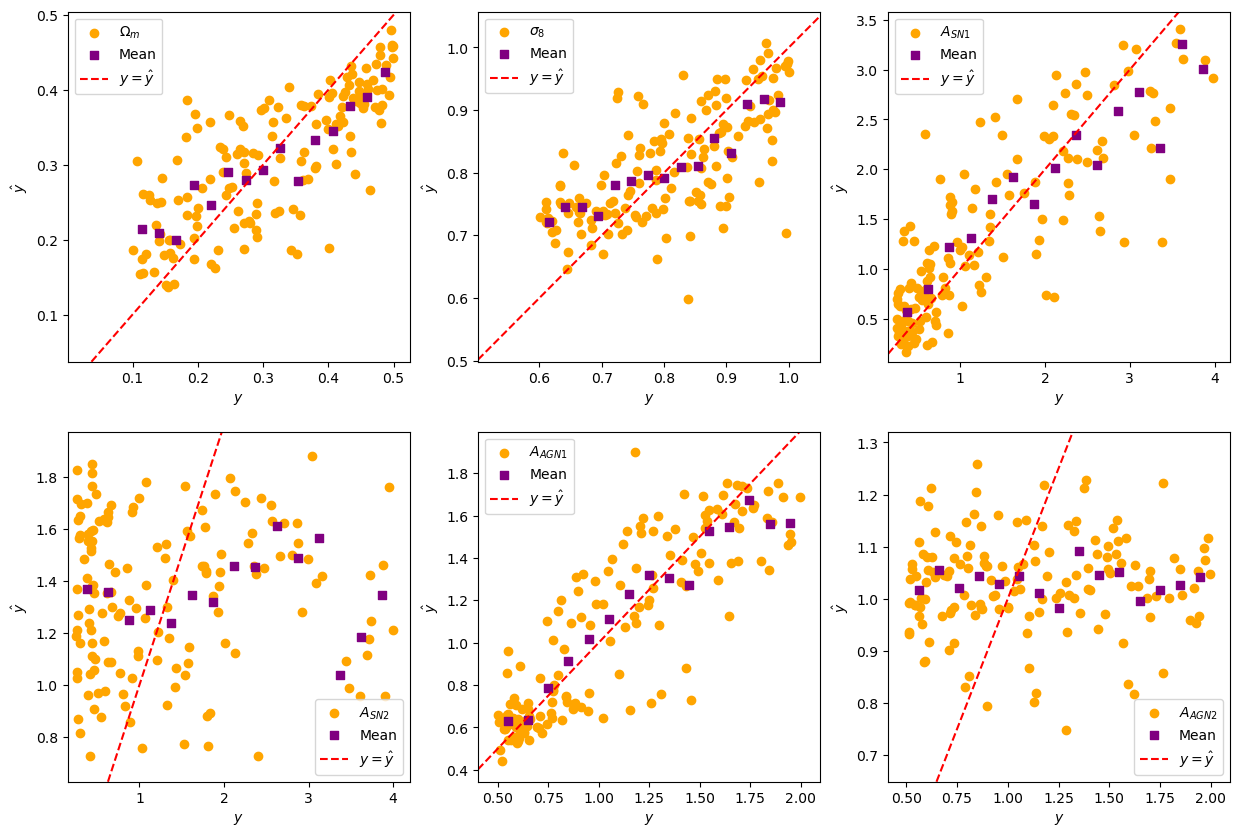

In [50]:
#destandardizziamo e denormalizziamo i dati  e plottiamo il confronto tra i parametri attesi ed i parametri predetti dal modello
X = DATA.array_destd('input', torch.from_numpy(x_values))
Y = DATA.array_denorm('output', torch.from_numpy(y_true))
Yhat = DATA.array_denorm('output', torch.from_numpy(y_NN))

fig, ax = plt.subplots(2, 3, figsize = (15, 10))
labels = ['$\Omega_m$', '$\sigma_8$', '$A_{SN1}$', '$A_{SN2}$', '$A_{AGN1}$', '$A_{AGN2}$']

for i in range(y_true.shape[1]):
    ax[i//3, i%3].scatter(Y[:, i], Yhat[:, i], label = labels[i], color = 'orange')
    mean, bin_edges_x, binnumber = stats.binned_statistic(Y[:, i], Yhat[:, i], statistic = np.mean, bins = 15)
    
    ax[i//3, i%3].scatter(bin_edges_x[:-1]+0.5*np.diff(bin_edges_x), mean, label = 'Mean', marker = 's', color = 'purple')
    ax[i//3, i%3].axline((0, 0), slope = 1, color = 'r', linestyle = '--', label = "$y=\hat{y}$")
    
    ax[i//3, i%3].set_xlabel('$y$')
    ax[i//3, i%3].set_ylabel('$\hat{y}$')
    ax[i//3, i%3].set_xlim(left = (Y[:, i].min()-0.1))
    ax[i//3, i%3].set_ylim(bottom = (Yhat[:, i].min()-0.1))
    ax[i//3, i%3].legend()

plt.show()

In prima analisi, i pannelli sopra sembrano indicare che il modello si comporti bene su ogni parametro al netto di $A_{SN2}$ e $A_{AGN2}$. Una possibile spiegazione di tale fatto è che la funzione che vogliamo approssimare con la rete non abbia una grande correlazione con tali parametri. In alternativa potrebbe esserci una degenerazione, una forte correlazione tra i parametri. Una possibilità è quella di ricavare le distribuzioni a posteriori degli errori commessi dal modello.

Removed no burn in


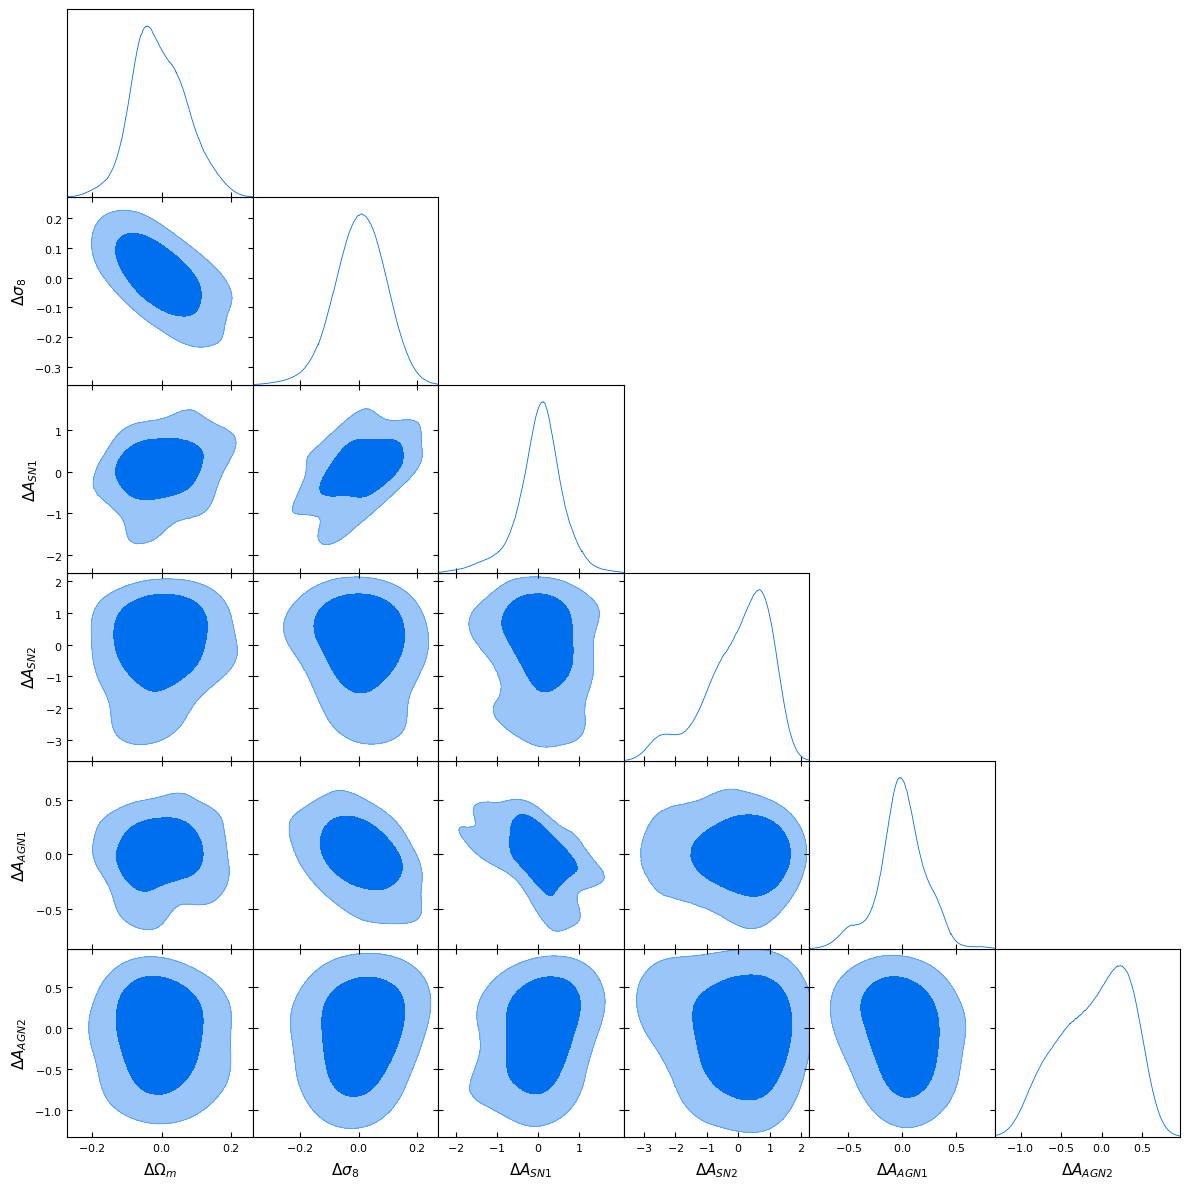

In [31]:
#ricaviamo le distribuzioni a posteriori degli errori commessi dal modello sui parametri
Y_np, Yhat_np = Y.cpu().numpy(), Yhat.cpu().numpy()
error = Yhat_np-Y_np
params_names = ['Omega_m', 'sigma_8', 'A_SN1', 'A_SN2', 'A_AGN1', 'A_AGN2']
params_labels = [r"\Delta\Omega_m", r"\Delta\sigma_8", r"\Delta A_{SN1}", r"\Delta A_{SN2}", r"\Delta A_{AGN1}", r"\Delta A_{AGN2}"]
mcsamples = MCSamples(samples = error, names = params_names, labels = params_labels)
g = plots.get_subplot_plotter()
g.triangle_plot(mcsamples, filled=True)
plt.show()

Si può osservare che le distribuzioni di tutti gli errori sono centrate attorno a zero a meno di quelle di $A_{SN2}$ e $A_{AGN2}$. In effetti, questi erano proprio i parametri che dai grafici sopra sembravano non essere stati ben stimati.

### 5. Addestramento di un modello ottimizzato per la stima dei parametri ed errori associati

Possiamo ripetere l'esprimento creando una rete neurale che tenti di predire anche gli errori statistici sui parametri. Per farlo, modifichiamo leggermente la loss, introducendo un termine che si minimizzi riducendo la distanza tra le predizioni degli errori statistici e gli scarti quadratici. Considereremo il logaritmo di tali quantità in quanto il logaritmo è una funzione crescente e ci permette di gestire meglio numeri grandi, che potrebbero rendere le operazioni numericamente instabili. Analogamente, modifichiamo la funzione obiettivo per utilizzare la nuova loss introdotta. Non calcolando una loss media per batch, nella funzione di training passiamo il parametro `mean_loss = False` che fa in modo che, nel calcolo della loss totale, non si moltiplichi il contributo di ogni batch per il numero di elementi nel batch (non c'è stata divisione nel calcolo della loss) per ottenere la somma degli scarti quadratici.

\begin{equation*}
    \mathcal{L} = \log \sum_i (y_i-\hat{y}_i)^2+\log\sum_i ((y_i-\hat{y}_i)^2-\sigma_i^2)
\end{equation*}

In [11]:
class sigma_loss(nn.Module): #definiamo la loss per la stima di parametri ed incertezze statistiche
    def __init__(self):
        super(sigma_loss, self).__init__()
    def forward(self, y_pred, y_train):
        residuals = y_train[:,:6]-y_pred[:,:6]
        L = torch.log(torch.sum(residuals**2))+torch.log(torch.sum((residuals**2-y_pred[:,6:12]**2)**2))
        return L

def sigma_objective(trial): #definiamo la funzione obiettivo per la nuova rete
    global sigma_Nin, sigma_Nout, train_loader, valid_loader, sigma_f_model, sigma_prune

    #esploriamo lo spazio degli iperparametri: learning rate, numero di strati nascosti e di neuroni per strato, il leak della LeakyReLU
    lr = trial.suggest_float('learning_rate', 1e-6, 1e-3, log = True)
    n_hidden = trial.suggest_int('n_hidden', 1, 5)
    hidden_layers = [trial.suggest_int(f'hidden_{i+1}', 1, 100, log = True) for i in range(n_hidden)]
    leak = trial.suggest_float('leak', -1, 1)
    
    activations = []
    for i in range(n_hidden):
        activation = nn.LeakyReLU(leak)
        activations.append(activation)
    activations.append(nn.Identity())

    epochs = 100 #100
    wd = 1e-4
    factor = 0.3
    patience = 40
    min_lr = 0.1e-6
    stop_criterion = 60
    loss_func = sigma_loss()
    min_valid_loss_param = 1e100
    
    model = network_init(n_in = sigma_Nin, n_out = sigma_Nout, hidden_layers = hidden_layers, activations = activations)
    train_value, valid_value, epoch_best_model, min_valid_loss = network_train(model, lr, wd, factor, patience, 
                                                                               min_lr, epochs, stop_criterion,
                                                                               loss_func, min_valid_loss_param,
                                                                               train_loader, valid_loader, sigma_f_model, 
                                                                               verbose = False, trial = trial, prune = sigma_prune,
                                                                               mean_loss = False)

    return min_valid_loss

Dunque, posti i parametri fissi della rete, usiamo `optuna` per ottimizzare gli iperparametri, creiamo il nuovo modello con gli iperparametri ottimizzati ed addestriamolo.

In [12]:
#fissiamo i parametri di base per la rete
sigma_Nin = 100
sigma_Nout = 12
sigma_f_model = 'best_sigma_model.pt'
sigma_prune = True

In [36]:
#esploriamo lo spazio degli iperparametri per ottimizzarlo
study = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(), pruner = optuna.pruners.PercentilePruner(80.0))
study.optimize(sigma_objective, n_trials = 50, show_progress_bar = True)#50

[I 2025-12-09 04:31:52,818] A new study created in memory with name: no-name-6eda54e0-de6d-4ed5-aa14-93ee8abaf241
Best trial: 0. Best value: 0.0853353:   2%|▏         | 1/50 [00:03<02:57,  3.62s/it]

[I 2025-12-09 04:31:56,445] Trial 0 finished with value: 0.0853352689743042 and parameters: {'learning_rate': 3.413373656234019e-05, 'n_hidden': 3, 'hidden_1': 6, 'hidden_2': 6, 'hidden_3': 29, 'leak': -0.4678592767121148}. Best is trial 0 with value: 0.0853352689743042.


Best trial: 0. Best value: 0.0853353:   4%|▍         | 2/50 [00:07<03:12,  4.00s/it]

[I 2025-12-09 04:32:00,719] Trial 1 finished with value: 0.09001649538675945 and parameters: {'learning_rate': 1.8838075808833804e-05, 'n_hidden': 5, 'hidden_1': 1, 'hidden_2': 10, 'hidden_3': 100, 'hidden_4': 4, 'hidden_5': 28, 'leak': 0.029237043707958765}. Best is trial 0 with value: 0.0853352689743042.


Best trial: 0. Best value: 0.0853353:   6%|▌         | 3/50 [00:10<02:41,  3.43s/it]

[I 2025-12-09 04:32:03,464] Trial 2 finished with value: 0.23134716351826987 and parameters: {'learning_rate': 1.0866101373617743e-06, 'n_hidden': 2, 'hidden_1': 3, 'hidden_2': 59, 'leak': 0.029482410308136586}. Best is trial 0 with value: 0.0853352689743042.


Best trial: 0. Best value: 0.0853353:   8%|▊         | 4/50 [00:13<02:23,  3.12s/it]

[I 2025-12-09 04:32:06,118] Trial 3 finished with value: 0.2416690731048584 and parameters: {'learning_rate': 1.5127294343550333e-05, 'n_hidden': 2, 'hidden_1': 3, 'hidden_2': 1, 'leak': -0.9776127240191268}. Best is trial 0 with value: 0.0853352689743042.


Best trial: 4. Best value: 0.0648965:  12%|█▏        | 6/50 [00:17<01:41,  2.31s/it]

[I 2025-12-09 04:32:10,028] Trial 4 finished with value: 0.06489647467931112 and parameters: {'learning_rate': 0.00010338372875981402, 'n_hidden': 3, 'hidden_1': 15, 'hidden_2': 5, 'hidden_3': 13, 'leak': 0.5482454150157188}. Best is trial 4 with value: 0.06489647467931112.
[I 2025-12-09 04:32:10,111] Trial 5 pruned. 


Best trial: 4. Best value: 0.0648965:  14%|█▍        | 7/50 [00:17<01:08,  1.59s/it]

[I 2025-12-09 04:32:10,316] Trial 6 pruned. 


Best trial: 4. Best value: 0.0648965:  16%|█▌        | 8/50 [00:20<01:30,  2.15s/it]

[I 2025-12-09 04:32:13,680] Trial 7 finished with value: 0.08272031625111897 and parameters: {'learning_rate': 0.00044980015718441477, 'n_hidden': 5, 'hidden_1': 10, 'hidden_2': 1, 'hidden_3': 13, 'hidden_4': 12, 'hidden_5': 3, 'leak': 0.8580713696153894}. Best is trial 4 with value: 0.06489647467931112.


[I 2025-12-09 04:32:16,452] Trial 8 finished with value: 0.2185817050933838 and parameters: {'learning_rate': 1.6576351054886793e-06, 'n_hidden': 4, 'hidden_1': 1, 'hidden_2': 8, 'hidden_3': 5, 'hidden_4': 33, 'leak': -0.3870116861932522}. Best is trial 4 with value: 0.06489647467931112.
[I 2025-12-09 04:32:16,494] Trial 9 pruned. 


Best trial: 4. Best value: 0.0648965:  22%|██▏       | 11/50 [00:23<00:50,  1.29s/it]

[I 2025-12-09 04:32:16,647] Trial 10 pruned. 
[I 2025-12-09 04:32:16,707] Trial 11 pruned. 


Best trial: 4. Best value: 0.0648965:  28%|██▊       | 14/50 [00:30<01:01,  1.70s/it]

[I 2025-12-09 04:32:23,432] Trial 12 finished with value: 0.06493488470713298 and parameters: {'learning_rate': 0.0009995879160808435, 'n_hidden': 4, 'hidden_1': 16, 'hidden_2': 2, 'hidden_3': 20, 'hidden_4': 9, 'leak': 0.9504608489204249}. Best is trial 4 with value: 0.06489647467931112.
[I 2025-12-09 04:32:23,624] Trial 13 pruned. 


Best trial: 4. Best value: 0.0648965:  32%|███▏      | 16/50 [00:31<00:34,  1.03s/it]

[I 2025-12-09 04:32:23,785] Trial 14 pruned. 
[I 2025-12-09 04:32:23,936] Trial 15 pruned. 


Best trial: 4. Best value: 0.0648965:  38%|███▊      | 19/50 [00:31<00:16,  1.89it/s]

[I 2025-12-09 04:32:23,988] Trial 16 pruned. 
[I 2025-12-09 04:32:24,036] Trial 17 pruned. 
[I 2025-12-09 04:32:24,172] Trial 18 pruned. 


Best trial: 4. Best value: 0.0648965:  42%|████▏     | 21/50 [00:31<00:11,  2.59it/s]

[I 2025-12-09 04:32:24,244] Trial 19 pruned. 
[I 2025-12-09 04:32:24,374] Trial 20 pruned. 


Best trial: 4. Best value: 0.0648965:  44%|████▍     | 22/50 [00:35<00:31,  1.12s/it]

[I 2025-12-09 04:32:28,559] Trial 21 finished with value: 0.07972687403361002 and parameters: {'learning_rate': 0.00044890483952848153, 'n_hidden': 5, 'hidden_1': 10, 'hidden_2': 1, 'hidden_3': 13, 'hidden_4': 11, 'hidden_5': 2, 'leak': 0.8205318469874046}. Best is trial 4 with value: 0.06489647467931112.


Best trial: 4. Best value: 0.0648965:  46%|████▌     | 23/50 [00:39<00:44,  1.65s/it]

[I 2025-12-09 04:32:32,136] Trial 22 finished with value: 0.06543408791224162 and parameters: {'learning_rate': 0.00044972571066610723, 'n_hidden': 5, 'hidden_1': 5, 'hidden_2': 2, 'hidden_3': 6, 'hidden_4': 6, 'hidden_5': 8, 'leak': 0.8242226890898231}. Best is trial 4 with value: 0.06489647467931112.


Best trial: 23. Best value: 0.0633876:  48%|████▊     | 24/50 [00:42<00:54,  2.09s/it]

[I 2025-12-09 04:32:35,681] Trial 23 finished with value: 0.06338762362798055 and parameters: {'learning_rate': 0.0009712697325525053, 'n_hidden': 5, 'hidden_1': 4, 'hidden_2': 2, 'hidden_3': 5, 'hidden_4': 4, 'hidden_5': 21, 'leak': 0.598501193153958}. Best is trial 23 with value: 0.06338762362798055.
[I 2025-12-09 04:32:35,739] Trial 24 pruned. 


Best trial: 23. Best value: 0.0633876:  52%|█████▏    | 26/50 [00:45<00:43,  1.79s/it]

[I 2025-12-09 04:32:38,374] Trial 25 finished with value: 0.08305811246236165 and parameters: {'learning_rate': 0.0002860488478222835, 'n_hidden': 4, 'hidden_1': 2, 'hidden_2': 3, 'hidden_3': 2, 'hidden_4': 2, 'leak': 0.585540997568856}. Best is trial 23 with value: 0.06338762362798055.


Best trial: 26. Best value: 0.0624511:  54%|█████▍    | 27/50 [00:50<00:57,  2.50s/it]

[I 2025-12-09 04:32:43,307] Trial 26 finished with value: 0.0624511448542277 and parameters: {'learning_rate': 0.00011253902069089968, 'n_hidden': 5, 'hidden_1': 18, 'hidden_2': 10, 'hidden_3': 20, 'hidden_4': 25, 'hidden_5': 93, 'leak': 0.12471015897157298}. Best is trial 26 with value: 0.0624511448542277.


Best trial: 26. Best value: 0.0624511:  56%|█████▌    | 28/50 [00:59<01:31,  4.14s/it]

[I 2025-12-09 04:32:52,632] Trial 27 finished with value: 0.0659255035718282 and parameters: {'learning_rate': 7.318043018569748e-05, 'n_hidden': 5, 'hidden_1': 23, 'hidden_2': 13, 'hidden_3': 9, 'hidden_4': 28, 'hidden_5': 71, 'leak': -0.12064492951791535}. Best is trial 26 with value: 0.0624511448542277.


Best trial: 26. Best value: 0.0624511:  58%|█████▊    | 29/50 [01:10<02:00,  5.73s/it]

[I 2025-12-09 04:33:02,981] Trial 28 finished with value: 0.06629655440648397 and parameters: {'learning_rate': 3.2521977305047276e-05, 'n_hidden': 5, 'hidden_1': 2, 'hidden_2': 26, 'hidden_3': 55, 'hidden_4': 57, 'hidden_5': 92, 'leak': 0.14438942506347538}. Best is trial 26 with value: 0.0624511448542277.
[I 2025-12-09 04:33:03,063] Trial 29 pruned. 


Best trial: 26. Best value: 0.0624511:  64%|██████▍   | 32/50 [01:10<00:46,  2.61s/it]

[I 2025-12-09 04:33:03,197] Trial 30 pruned. 
[I 2025-12-09 04:33:03,338] Trial 31 pruned. 


Best trial: 32. Best value: 0.0622574:  66%|██████▌   | 33/50 [01:15<00:54,  3.19s/it]

[I 2025-12-09 04:33:08,237] Trial 32 finished with value: 0.06225736141204834 and parameters: {'learning_rate': 0.0007135350079035832, 'n_hidden': 5, 'hidden_1': 25, 'hidden_2': 6, 'hidden_3': 23, 'hidden_4': 2, 'hidden_5': 24, 'leak': 0.1255932766444856}. Best is trial 32 with value: 0.06225736141204834.


Best trial: 33. Best value: 0.0606329:  68%|██████▊   | 34/50 [01:21<01:03,  3.99s/it]

[I 2025-12-09 04:33:14,525] Trial 33 finished with value: 0.060632944107055664 and parameters: {'learning_rate': 0.0005964759820794018, 'n_hidden': 5, 'hidden_1': 28, 'hidden_2': 6, 'hidden_3': 51, 'hidden_4': 2, 'hidden_5': 25, 'leak': 0.11820927623102846}. Best is trial 33 with value: 0.060632944107055664.


Best trial: 33. Best value: 0.0606329:  70%|███████   | 35/50 [01:27<01:06,  4.42s/it]

[I 2025-12-09 04:33:20,074] Trial 34 finished with value: 0.06268459558486938 and parameters: {'learning_rate': 0.0005417605688045687, 'n_hidden': 5, 'hidden_1': 27, 'hidden_2': 11, 'hidden_3': 49, 'hidden_4': 2, 'hidden_5': 21, 'leak': 0.07745484544836845}. Best is trial 33 with value: 0.060632944107055664.


Best trial: 33. Best value: 0.0606329:  74%|███████▍  | 37/50 [01:33<00:47,  3.62s/it]

[I 2025-12-09 04:33:26,671] Trial 35 finished with value: 0.06163557449976603 and parameters: {'learning_rate': 0.0006071432316918298, 'n_hidden': 5, 'hidden_1': 32, 'hidden_2': 12, 'hidden_3': 52, 'hidden_4': 2, 'hidden_5': 37, 'leak': 0.057560436269553455}. Best is trial 33 with value: 0.060632944107055664.
[I 2025-12-09 04:33:26,789] Trial 36 pruned. 


Best trial: 33. Best value: 0.0606329:  76%|███████▌  | 38/50 [01:40<00:53,  4.47s/it]

[I 2025-12-09 04:33:33,330] Trial 37 finished with value: 0.07023396333058675 and parameters: {'learning_rate': 0.0006260956833074203, 'n_hidden': 5, 'hidden_1': 39, 'hidden_2': 7, 'hidden_3': 95, 'hidden_4': 1, 'hidden_5': 39, 'leak': 0.10375860529088508}. Best is trial 33 with value: 0.060632944107055664.


Best trial: 33. Best value: 0.0606329:  78%|███████▊  | 39/50 [01:40<00:35,  3.22s/it]

[I 2025-12-09 04:33:33,535] Trial 38 pruned. 


Best trial: 39. Best value: 0.0581161:  80%|████████  | 40/50 [01:46<00:39,  3.94s/it]

[I 2025-12-09 04:33:39,181] Trial 39 finished with value: 0.05811605215072632 and parameters: {'learning_rate': 0.000600073813150999, 'n_hidden': 5, 'hidden_1': 31, 'hidden_2': 41, 'hidden_3': 37, 'hidden_4': 3, 'hidden_5': 44, 'leak': -0.5792504042442755}. Best is trial 39 with value: 0.05811605215072632.


Best trial: 39. Best value: 0.0581161:  82%|████████▏ | 41/50 [01:46<00:25,  2.87s/it]

[I 2025-12-09 04:33:39,511] Trial 40 pruned. 
[I 2025-12-09 04:33:39,615] Trial 41 pruned. 


Best trial: 39. Best value: 0.0581161:  86%|████████▌ | 43/50 [01:50<00:17,  2.46s/it]

[I 2025-12-09 04:33:43,465] Trial 42 finished with value: 0.06111889362335205 and parameters: {'learning_rate': 0.0001949734091663976, 'n_hidden': 5, 'hidden_1': 13, 'hidden_2': 32, 'hidden_3': 24, 'hidden_4': 2, 'hidden_5': 100, 'leak': -0.5800947131102288}. Best is trial 39 with value: 0.05811605215072632.


Best trial: 39. Best value: 0.0581161:  90%|█████████ | 45/50 [01:55<00:11,  2.31s/it]

[I 2025-12-09 04:33:48,326] Trial 43 finished with value: 0.06272343317667643 and parameters: {'learning_rate': 0.0006649040254761325, 'n_hidden': 5, 'hidden_1': 30, 'hidden_2': 72, 'hidden_3': 34, 'hidden_4': 2, 'hidden_5': 36, 'leak': -0.5738521341208674}. Best is trial 39 with value: 0.05811605215072632.
[I 2025-12-09 04:33:48,519] Trial 44 pruned. 


Best trial: 45. Best value: 0.0510703:  92%|█████████▏| 46/50 [02:01<00:12,  3.12s/it]

[I 2025-12-09 04:33:53,794] Trial 45 finished with value: 0.05107031027475993 and parameters: {'learning_rate': 0.0006436822092269657, 'n_hidden': 5, 'hidden_1': 41, 'hidden_2': 92, 'hidden_3': 69, 'hidden_4': 4, 'hidden_5': 53, 'leak': -0.6631918126522499}. Best is trial 45 with value: 0.05107031027475993.


Best trial: 45. Best value: 0.0510703:  94%|█████████▍| 47/50 [02:07<00:12,  4.01s/it]

[I 2025-12-09 04:34:00,125] Trial 46 finished with value: 0.06444603045781454 and parameters: {'learning_rate': 0.00039325399883921824, 'n_hidden': 4, 'hidden_1': 40, 'hidden_2': 96, 'hidden_3': 94, 'hidden_4': 4, 'leak': -0.5481281743912344}. Best is trial 45 with value: 0.05107031027475993.


Best trial: 45. Best value: 0.0510703:  96%|█████████▌| 48/50 [02:13<00:09,  4.77s/it]

[I 2025-12-09 04:34:06,742] Trial 47 finished with value: 0.07496546665827433 and parameters: {'learning_rate': 0.0005299653168604222, 'n_hidden': 5, 'hidden_1': 61, 'hidden_2': 53, 'hidden_3': 68, 'hidden_4': 1, 'hidden_5': 60, 'leak': -0.8072329659704696}. Best is trial 45 with value: 0.05107031027475993.


Best trial: 45. Best value: 0.0510703: 100%|██████████| 50/50 [02:14<00:00,  2.69s/it]

[I 2025-12-09 04:34:07,025] Trial 48 pruned. 
[I 2025-12-09 04:34:07,099] Trial 49 pruned. 


In [37]:
best_trial = study.best_trial.params
torch.save(best_trial, 'best_sigma_hyperparams.pt')
print(best_trial)

{'learning_rate': 0.0006436822092269657, 'n_hidden': 5, 'hidden_1': 41, 'hidden_2': 92, 'hidden_3': 69, 'hidden_4': 4, 'hidden_5': 53, 'leak': -0.6631918126522499}


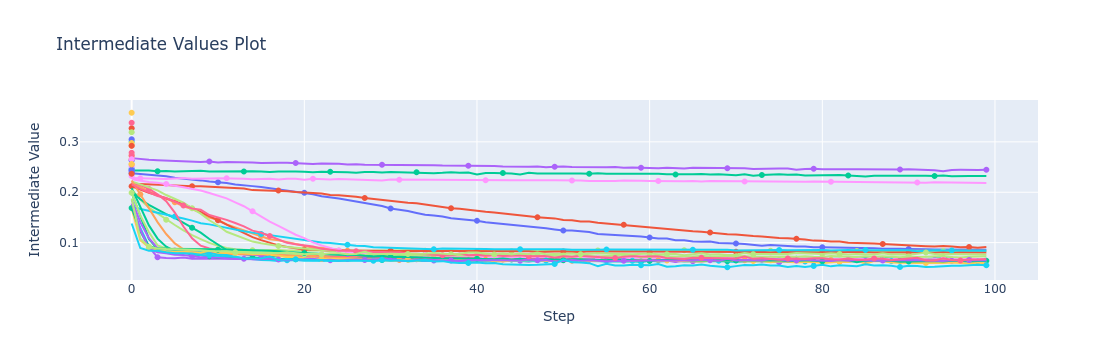

In [38]:
optuna.visualization.plot_intermediate_values(study)

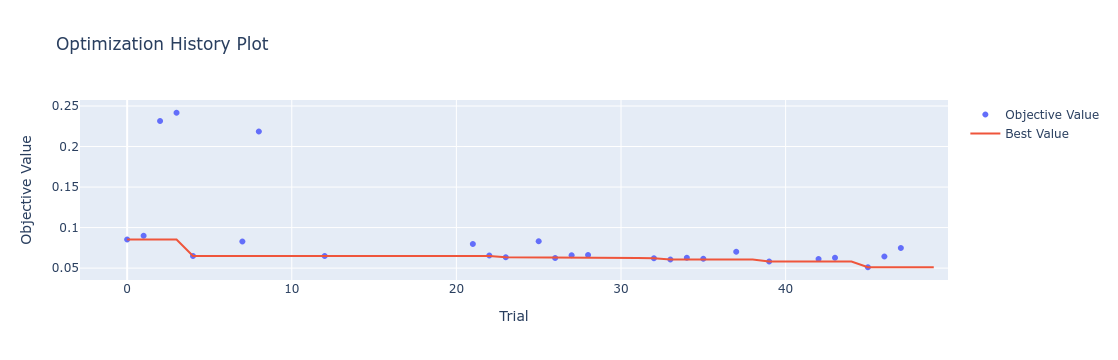

In [39]:
optuna.visualization.plot_optimization_history(study)

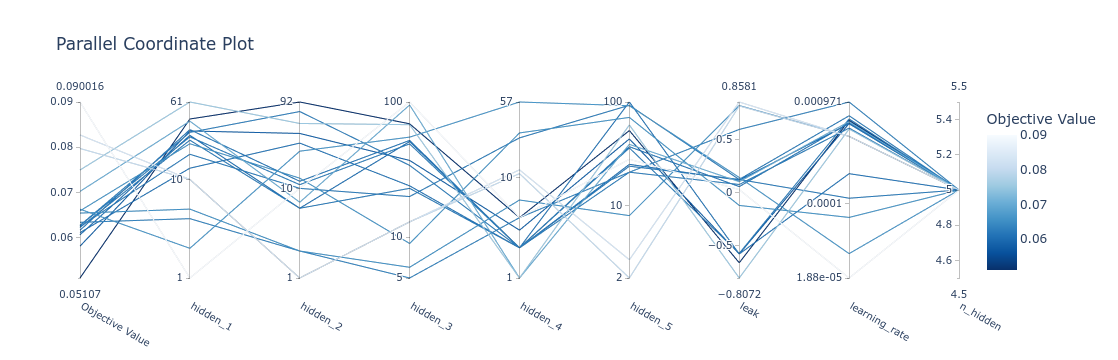

In [40]:
optuna.visualization.plot_parallel_coordinate(study)

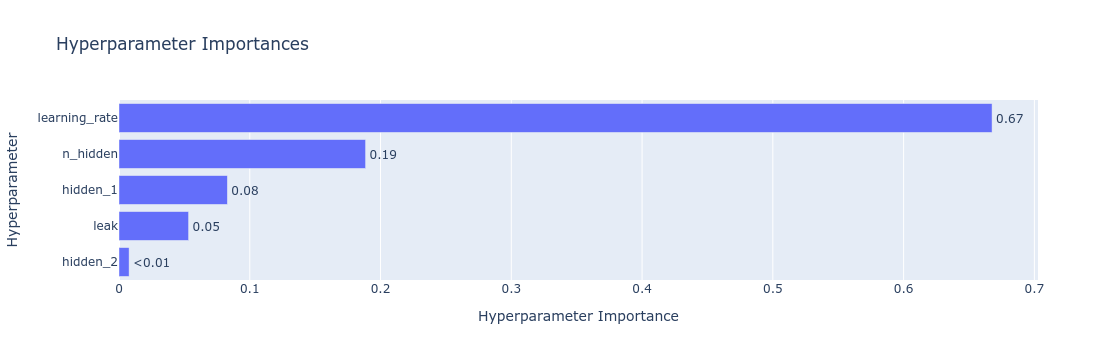

In [41]:
optuna.visualization.plot_param_importances(study)

In [13]:
#carichiamo gli iperparametri della rete
best_trial = torch.load('best_sigma_hyperparams.pt')
keys = []
sigma_hidden_layers = []
for key, value in best_trial.items():
    if 'hidden_' in key:
        keys.append(key)
sorted_keys = sorted(keys, key = lambda x: int(x.split('_')[1]))
for key in sorted_keys:
    sigma_hidden_layers.append(best_trial[key])

sigma_lr = best_trial.get('learning_rate')
sigma_leak = best_trial.get('leak')
sigma_activations = []
for i in range(len(sigma_hidden_layers)):
    activation = nn.LeakyReLU(sigma_leak)
    sigma_activations.append(activation)
sigma_activations.append(nn.Identity())

epochs = 1000 #1k
wd = 1e-4
factor = 0.25 #0.25
patience = 50 #25
min_lr = 1e-6 #1e-6
stop_criterion = 600 #600
sigma_loss_func = sigma_loss()
min_valid_loss_param = 1e100

In [14]:
#definiamo la rete
sigma_model = network_init(n_in = sigma_Nin, n_out = sigma_Nout, hidden_layers = sigma_hidden_layers, activations = sigma_activations)

In [44]:
#addestriamo il modello
train_value, valid_value, epoch_best_model, min_valid_loss = network_train(sigma_model, sigma_lr, wd, factor, patience, 
                                                                           min_lr, epochs, stop_criterion,
                                                                           sigma_loss_func, min_valid_loss_param,
                                                                           train_loader, valid_loader, sigma_f_model, 
                                                                           verbose = True, mean_loss = False)

epoch:0, valid loss: 0.1567 (best-model), epoch:  0 , max epoch:  1000
epoch:1, valid loss: 0.0916 (best-model), epoch:  1 , max epoch:  1000
epoch:2, valid loss: 0.0830 (best-model), epoch:  2 , max epoch:  1000
epoch:3, valid loss: 0.0808 (best-model), epoch:  3 , max epoch:  1000
epoch:4, valid loss: 0.0779 (best-model), epoch:  4 , max epoch:  1000
epoch:5, valid loss: 0.0736 (best-model), epoch:  5 , max epoch:  1000
epoch:6, valid loss: 0.0722 (best-model), epoch:  6 , max epoch:  1000
epoch:7, valid loss: 0.0692 (best-model), epoch:  7 , max epoch:  1000
epoch:8, valid loss: 0.0697
epoch:9, valid loss: 0.0700
epoch:10, valid loss: 0.0685 (best-model), epoch:  10 , max epoch:  1000
epoch:11, valid loss: 0.0668 (best-model), epoch:  11 , max epoch:  1000
 (best-model), epoch:  12 , max epoch:  1000
epoch:13, valid loss: 0.0667
epoch:14, valid loss: 0.0683
epoch:15, valid loss: 0.0641 (best-model), epoch:  15 , max epoch:  1000
epoch:16, valid loss: 0.0663
epoch:17, valid loss: 0.0

In [45]:
torch.save(train_value, 'sigma_train_value.pt')
torch.save(valid_value, 'sigma_valid_value.pt')
torch.save(epoch_best_model, 'sigma_epoch_best_model.pt')
torch.save(min_valid_loss, 'sigma_min_valid_loss.pt')
print('Minimo della validation loss: ', min_valid_loss)

Minimo della validation loss:  0.056478657722473145


Anche in questo caso si osserva una rapida decrescenza delle funzioni di loss. In particolare, si può notare un leggero scarto tra le due una volta raggiunto il plateau. Questo potrebbe indicare un leggero overfitting del modello, quindi è buona pratica verificare la test loss.

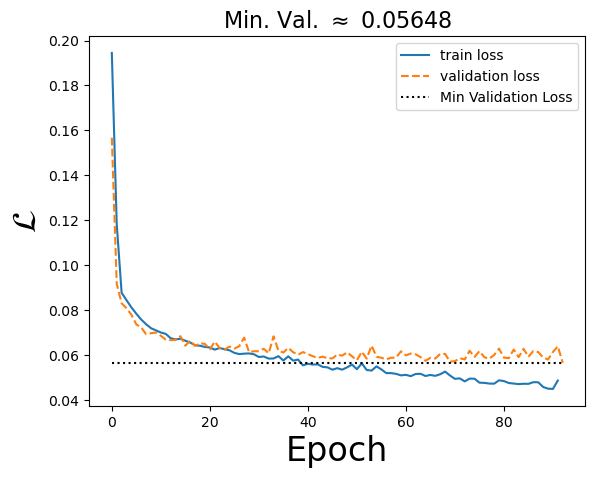

In [15]:
#plottiamo l'andamento delle funzioni di loss
train_value = torch.load('sigma_train_value.pt', weights_only = False)
valid_value = torch.load('sigma_valid_value.pt', weights_only = False)
epoch_best_model = torch.load('sigma_epoch_best_model.pt', weights_only = False)
min_valid_loss = torch.load('sigma_min_valid_loss.pt', weights_only = False)
epoche_train = np.arange(epoch_best_model)
epoche_valid = np.arange(epoch_best_model+1)
mvl = float(min_valid_loss)*np.ones_like(epoche_valid)

plt.plot(epoche_train, train_value[:epoch_best_model], label = 'train loss')
plt.plot(epoche_valid, valid_value[:epoch_best_model+1], ls = '--', label = 'validation loss')
plt.plot(epoche_valid, mvl, label = 'Min Validation Loss', ls = ':', color = 'k')
plt.xlabel("Epoch", fontsize = 24)
plt.ylabel("$\mathcal{L}$", fontsize = 24)
plt.title(f'Min. Val. $\\approx$ {round(float(min_valid_loss), 5)}', fontsize = 16)
plt.legend()
plt.show()

Come si può notare, anche questa volta la test loss ha lo stesso ordine di grandezza della validation loss.

In [16]:
#calcoliamo la loss sul test set
sigma_model.load_state_dict(torch.load(sigma_f_model, weights_only = True))
sigma_model.to(device = device)

x_values = np.zeros((len(test_loader.dataset), sigma_Nin))
y_true = np.zeros((len(test_loader.dataset), int(sigma_Nout/2)))
y_NN = np.zeros((len(test_loader.dataset), sigma_Nout))

test_loss, points = 0.0, 0
sigma_model.eval()

with torch.no_grad():
    for x_test, y_test in test_loader:
        bs = x_test.shape[0]

        x_test = x_test.to(device)
        y_test = y_test.to(device)
        y_pred = sigma_model(x_test)
        
        x_values[points:points+bs,:] = x_test.cpu().numpy()
        y_true[points:points+bs,:] = y_test.cpu().numpy()
        y_NN[points:points+bs,:] = y_pred.cpu().numpy()
        
        test_loss += (sigma_loss_func(y_pred, y_test).item())
        points += bs

test_loss /= points
print('test loss = %.3e'%test_loss)

test loss = 6.261e-02


Destandardizziamo e denormalizziamo i dati; come prima poi, plottiamo il confronto tra i risultati ottenuti dal modello ed i risultati presenti nel dataset. Plottiamo poi le barre d'errore ricavate con la regressione sugli errori statistici. <b>Nota:</b> alcuni dei valori predetti per gli errori statistici sono negativi. Questo è dovuto alla presenza di termini quadratici in $\sigma$ nella loss function, che rivela una simmetria

\begin{equation*}
\sigma\mapsto -\sigma
\end{equation*}

Ciò significa che nell'addestramento della rete, dal punto di vista della loss, diventa equivalente predire un valore o il suo opposto per quanto riguarda gli errori statistici e quindi basta che il gradiente punti nella direzione "opposta" (ovvero, basta che la loss diminuisca leggermente nella direzione di $-\sigma$) nel punto dello spazio dei parametri da cui si parte e l'allenamento della rete potrebbe portare verso il valore $-\sigma$. Per questo, considereremo esclusivamente i moduli del vettore sigma per ottenere i valori positivi.

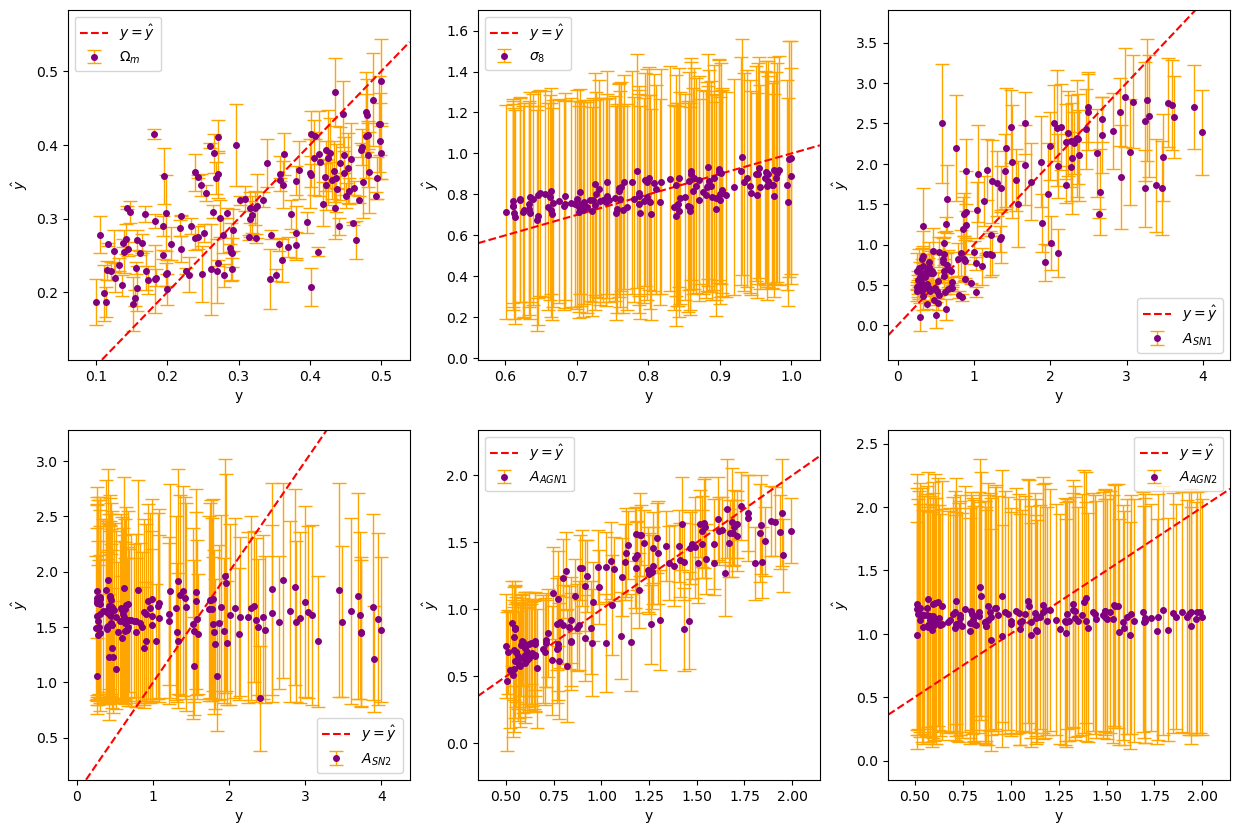

In [17]:
#destandardizziamo e denormalizziamo i dati  e plottiamo il confronto tra i parametri attesi ed i parametri predetti dal modello
# Yhat[:, :6] = predizioni parametri
# Yhat[:, 6:] = predizioni sigma (sui parametri normalizzati)

X = DATA.array_destd('input', torch.from_numpy(x_values))
Y = DATA.array_denorm('output', torch.from_numpy(y_true))
Yhat = DATA.array_denorm('output', torch.from_numpy(y_NN[:, :6]))
sigma = DATA.array_denorm('output', torch.from_numpy(y_NN[:, 6:]))

X = X.cpu().numpy()
Y = Y.cpu().numpy()
Yhat = Yhat.cpu().numpy()
sigma = sigma.cpu().numpy()
sigma = np.abs(sigma)

fig, ax = plt.subplots(2, 3, figsize = (15, 10))
labels = ['$\Omega_m$', '$\sigma_8$', '$A_{SN1}$', '$A_{SN2}$', '$A_{AGN1}$', '$A_{AGN2}$']

for i in range(y_true.shape[1]):
    xmin = (Y[:, i]).min()
    xmax = (Y[:, i]).max()
    ymin = (Yhat[:, i]-sigma[:, i]).min()
    ymax = (Yhat[:, i]+sigma[:, i]).max()

    dx = (xmax-xmin)/10
    dy = (ymax-ymin)/10
    
    ax[i//3, i%3].set_xlim(xmin-dx, xmax+dx)
    ax[i//3, i%3].set_ylim(ymin-dy, ymax+dy)
    ax[i//3, i%3].errorbar(Y[:, i], Yhat[:, i], yerr = sigma[:, i], label = labels[i], linestyle = '', color = 'purple',
                           ecolor = 'orange', capsize = 5, capthick = 1, elinewidth = 1, fmt = 'o', markersize = 4)
    ax[i//3, i%3].set_xlabel('y')
    ax[i//3, i%3].set_ylabel('$\hat{y}$')
    ax[i//3, i%3].axline((0, 0), slope = 1, color = 'r', linestyle = '--', label = "$y=\hat{y}$")
    ax[i//3, i%3].legend()

plt.show()

In generale, i risultati ottenuti da questa rete sembrano confermare quanto visto sopra. Ancora una volta, possiamo plottare i corner plot delle ditribuzioni a posteriori per gli errori commessi dal modello.

Removed no burn in


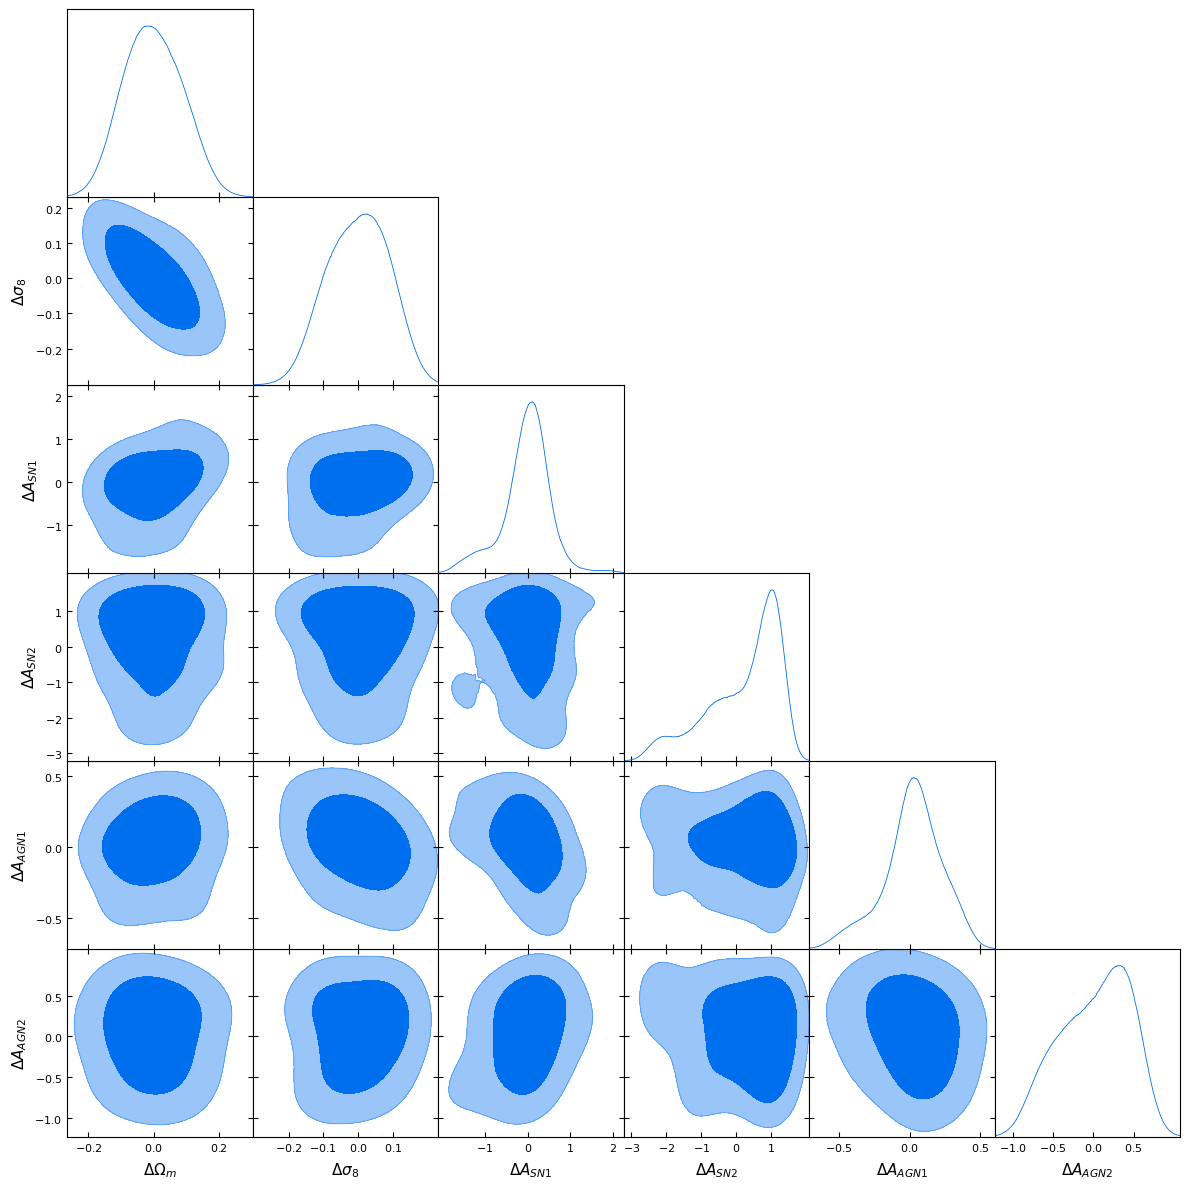

In [198]:
#ricaviamo le distribuzioni a posteriori delle previsioni del modello per i parametri
error = Yhat-Y
params_names = ['Omega_m', 'sigma_8', 'A_SN1', 'A_SN2', 'A_AGN1', 'A_AGN2']
params_labels = [r"\Delta\Omega_m", r"\Delta\sigma_8", r"\Delta A_{SN1}", r"\Delta A_{SN2}", r"\Delta A_{AGN1}", r"\Delta A_{AGN2}"]
mcsamples = MCSamples(samples = error, names = params_names, labels = params_labels)
g = plots.get_subplot_plotter()
g.triangle_plot(mcsamples, filled=True)
plt.show()

Anche qui, notiamo che le distribuzioni di tutti gli errori sono centrate attorno a zero a meno di quelle di $A_{SN2}$ e $A_{AGN2}$.

### 6. Effetto del data leakage nella standardizzazione/normalizzazione del dataset

Un effetto che può risultare curioso studiare è quello che si ottiene quando si standardizza/normalizza il dataset a partire dal dataset stesso intero, introducendo così un $data \ leakage$ dei dataset di validation e di test all'interno del dataset di train. Riscriviamo quindi la classe `make_dataset` per comportarsi in tale maniera.

In [202]:
class make_dataset: #creo la classe principale per la gestione dei dati
    def __init__(self, x, y, batch_size, seed): #richiedo input, output, grandezza dei batch e seed
        self.input, self.output = x, y
        self.batch_size = batch_size
        self.seed = seed
        self.n_train = self.input.shape[0] #ricavo il numero di esempi di addestramento presenti

    def split(self, perc_train = 0.7, perc_valid = 0.15): #questo metodo permette di splittare il dataset grezzo im train, validation e test
        self.perc_train, self.perc_valid = perc_train, perc_valid
        np.random.seed(self.seed) #seed fissato per la riproducibilità
        indexes = np.arange(self.n_train) #creo la lista degli indici
        np.random.shuffle(indexes) #mescolo la lista degli indici in modo casuale

        self.train_end = int(self.n_train*self.perc_train) #calcolo gli indici di fine training dataset e di fine validation dataset
        self.valid_end = int(self.n_train*(self.perc_train+self.perc_valid))

        train_indexes = indexes[:self.train_end] #estraggo il dataset di test
        valid_indexes = indexes[self.train_end:self.valid_end] #estraggo il dataset di validation
        test_indexes = indexes[self.valid_end:] #estraggo il dataset di test
        

        self.train_input  = torch.tensor(self.input[train_indexes], dtype=torch.float32) #memorizzo l'input train dataset nella classe
        self.train_output = torch.tensor(self.output[train_indexes], dtype=torch.float32) #analogamente per l'output train dataset

        self.valid_input  = torch.tensor(self.input[valid_indexes], dtype=torch.float32) #memorizzo l'input validation dataset nella classe
        self.valid_output = torch.tensor(self.output[valid_indexes], dtype=torch.float32) #analogamente per l'output del validation dataset
        
        self.test_input  = torch.tensor(self.input[test_indexes], dtype=torch.float32) #memorizzo l'input del test dataset nella classe
        self.test_output = torch.tensor(self.output[test_indexes], dtype=torch.float32) #analogamente per l'output del test dataset


        self.input_mean = self.input.mean(axis = 0) #calcolo media, varianza, minimo e massimo di input e output nnel dataset totale
        self.input_std = self.input.std(axis = 0)
        self.output_mean = self.output.mean(axis = 0) 
        self.output_std = self.output.std(axis = 0)

        self.input_mean = torch.tensor(self.input_mean, dtype=torch.float32)
        self.output_mean = torch.tensor(self.output_mean, dtype=torch.float32)
        self.input_std = torch.tensor(self.input_std, dtype=torch.float32)
        self.output_std = torch.tensor(self.output_std, dtype=torch.float32)
        
        self.input_MIN = torch.tensor(self.input, dtype=torch.float32).min(dim = 0)[0] 
        self.input_MAX = torch.tensor(self.input, dtype=torch.float32).max(dim = 0)[0]
        self.output_MIN = torch.tensor(self.output, dtype=torch.float32).min(dim = 0)[0]
        self.output_MAX = torch.tensor(self.output, dtype=torch.float32).max(dim = 0)[0]
        

    def std(self, io): #metodo di standardizzazione dei dataset rispetto al train dataset
        if io == 'input':
            self.train_input = (self.train_input-self.input_mean)/self.input_std
            self.valid_input = (self.valid_input-self.input_mean)/self.input_std
            self.test_input = (self.test_input-self.input_mean)/self.input_std
        elif io == 'output':
            self.train_output = (self.train_output-self.output_mean)/self.output_std
            self.valid_output = (self.valid_output-self.output_mean)/self.output_std
            self.test_output = (self.test_output-self.output_mean)/self.output_std
            
    def norm(self, io): #metodo di normalizazzione dei dataset rispetto al train dataset
        if io == 'input':
            self.train_input = (self.train_input-self.input_MIN)/(self.input_MAX-self.input_MIN)
            self.valid_input = (self.valid_input-self.input_MIN)/(self.input_MAX-self.input_MIN)
            self.test_input = (self.test_input-self.input_MIN)/(self.input_MAX-self.input_MIN)
        elif io == 'output':
            self.train_output = (self.train_output-self.output_MIN)/(self.output_MAX-self.output_MIN)
            self.valid_output = (self.valid_output-self.output_MIN)/(self.output_MAX-self.output_MIN)
            self.test_output = (self.test_output-self.output_MIN)/(self.output_MAX-self.output_MIN)

    def destd(self, io): #metodo di destandardizzazione dei dataset rispetto al train dataset
        if io == 'input':
            self.train_input = self.train_input*self.input_std+self.input_mean
            self.valid_input = self.valid_input*self.input_std+self.input_mean
            self.test_input = self.test_input*self.input_std+self.input_mean
        elif io == 'output':
            self.train_output = self.train_output*self.output_std+self.output_mean
            self.valid_output = self.valid_output*self.output_std+self.output_mean
            self.test_output = self.test_output*self.output_std+self.output_mean
            
    def denorm(self, io): #metodo di denormalizzazione dei dataset rispetto al train dataset
        if io == 'input':
            self.train_input = self.train_input*(self.input_MAX-self.input_MIN)+self.input_MIN
            self.valid_input = self.valid_input*(self.input_MAX-self.input_MIN)+self.input_MIN
            self.test_input = self.test_input*(self.input_MAX-self.input_MIN)+self.input_MIN
        elif io == 'output':
            self.train_output = self.train_output*(self.output_MAX-self.output_MIN)+self.output_MIN
            self.valid_output = self.valid_output*(self.output_MAX-self.output_MIN)+self.output_MIN
            self.test_output = self.test_output*(self.output_MAX-self.output_MIN)+self.output_MIN

    def array_std(self, io, vec): #metodo di standardizzazione di un vettore qualunque rispetto al train_dataset
        if io == 'input':
            vec = (vec-self.input_mean)/self.input_std
        elif io == 'output':
            vec = (vec-self.output_mean)/self.output_std
        return vec
        
    def array_norm(self, io, vec): #metodo di normalizzazione di un vettore qualunque rispetto al train dataset
        if io == 'input':
            vec = (vec-self.input_MIN)/(self.input_MAX-self.input_MIN)
        elif io == 'output':
            vec = (vec-self.output_MIN)/(self.output_MAX-self.output_MIN)
        return vec
        
    def array_destd(self, io, vec): #metodo di destandardizzazione di un vettore qualunque rispetto al train dataset
        if io == 'input':
            vec = vec*self.input_std+self.input_mean
        elif io == 'output':
            vec = vec*self.output_std+self.output_mean
        return vec
            
    def array_denorm(self, io, vec): #metodo di denormalizzazione di un vettore qualunque rispetto al train dataset
        if io == 'input':
            vec = vec*(self.input_MAX-self.input_MIN)+self.input_MIN
        elif io == 'output':
            vec = vec*(self.output_MAX-self.output_MIN)+self.output_MIN
        return vec    
        
    def create_loader(self): #metodo per la creazione dei data loader
        self.train_data = dataset(self.train_input, self.train_output) #¢reazione di oggetti dataset per il passaggio a dataloader
        self.valid_data = dataset(self.valid_input, self.valid_output)
        self.test_data = dataset(self.test_input, self.test_output)

        #creazione dei dataloader
        train_loader = DataLoader(dataset = self.train_data, batch_size = self.batch_size, shuffle = True)
        valid_loader = DataLoader(dataset = self.valid_data, batch_size = self.batch_size, shuffle = True)
        test_loader = DataLoader(dataset = self.test_data, batch_size = self.batch_size, shuffle = True)

        return train_loader, valid_loader, test_loader
        

Ripetiamo l'addestramento della stessa rete del punto 4 e valutiamone le prestazioni.

In [205]:
#prepariamo gli iperparametri per l'addestramento del modello
best_trial = torch.load('best_hyperparams.pt')
keys = []
hidden_layers = []
for key, value in best_trial.items():
    if 'hidden_' in key:
        keys.append(key)
sorted_keys = sorted(keys, key = lambda x: int(x.split('_')[1]))
for key in sorted_keys:
    hidden_layers.append(best_trial[key])

lr = best_trial.get('learning_rate')
leak = best_trial.get('leak')
activations = []
for i in range(len(hidden_layers)):
    activation = nn.LeakyReLU(leak)
    activations.append(activation)
activations.append(nn.Identity())

epochs = 1000 #1k
wd = 1e-4
factor = 0.25 #0.25
patience = 50 #25
min_lr = 1e-6 #1e-6
stop_criterion = 600 #600
loss_func = nn.MSELoss()
min_valid_loss_param = 1e100

model = network_init(n_in = Nin, n_out = Nout, hidden_layers = hidden_layers, activations = activations)
train_value, valid_value, epoch_best_model, min_valid_loss = network_train(model, lr, wd, factor, patience, 
                                                                           min_lr, epochs, stop_criterion,
                                                                           loss_func, min_valid_loss_param,
                                                                           train_loader, valid_loader, f_model, verbose = True)


epoch:0, valid loss: 0.1298 (best-model), epoch:  0 , max epoch:  1000
epoch:1, valid loss: 0.0797 (best-model), epoch:  1 , max epoch:  1000
epoch:2, valid loss: 0.0642 (best-model), epoch:  2 , max epoch:  1000
epoch:3, valid loss: 0.0594 (best-model), epoch:  3 , max epoch:  1000
epoch:4, valid loss: 0.0570 (best-model), epoch:  4 , max epoch:  1000
epoch:5, valid loss: 0.0541 (best-model), epoch:  5 , max epoch:  1000
epoch:6, valid loss: 0.0544
epoch:7, valid loss: 0.0522 (best-model), epoch:  7 , max epoch:  1000
 (best-model), epoch:  8 , max epoch:  1000
epoch:9, valid loss: 0.0510 (best-model), epoch:  9 , max epoch:  1000
epoch:10, valid loss: 0.0505 (best-model), epoch:  10 , max epoch:  1000
epoch:11, valid loss: 0.0497 (best-model), epoch:  11 , max epoch:  1000
epoch:12, valid loss: 0.0495 (best-model), epoch:  12 , max epoch:  1000
epoch:13, valid loss: 0.0489 (best-model), epoch:  13 , max epoch:  1000
epoch:14, valid loss: 0.0492
epoch:15, valid loss: 0.0500
epoch:16, 

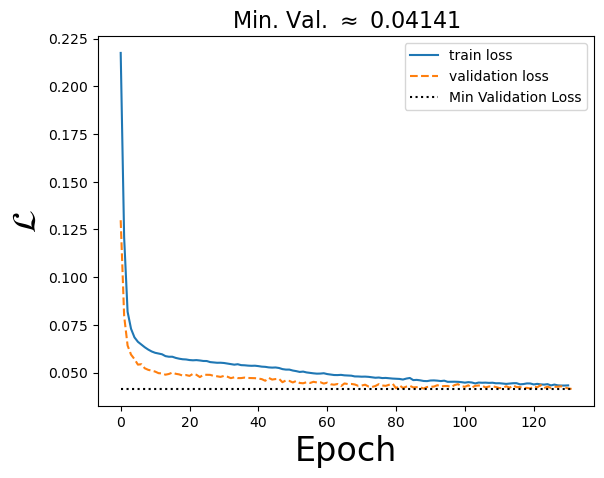

test loss = 4.939e-02


In [206]:
epoche_train = np.arange(epoch_best_model)
epoche_valid = np.arange(epoch_best_model+1)
mvl = float(min_valid_loss)*np.ones_like(epoche_valid)

plt.plot(epoche_train, train_value[:epoch_best_model], label = 'train loss')
plt.plot(epoche_valid, valid_value[:epoch_best_model+1], ls = '--', label = 'validation loss')
plt.plot(epoche_valid, mvl, label = 'Min Validation Loss', ls = ':', color = 'k')

plt.xlabel("Epoch", fontsize = 24)
plt.ylabel("$\mathcal{L}$", fontsize = 24)
plt.title(f'Min. Val. $\\approx$ {round(float(min_valid_loss), 5)}', fontsize = 16)
plt.legend()
plt.show()

#calcoliamo la test loss
model.load_state_dict(torch.load(f_model, weights_only = True))
model.to(device = device)

x_values = np.zeros((len(test_loader.dataset), Nin))
y_true = np.zeros((len(test_loader.dataset), Nout))
y_NN = np.zeros((len(test_loader.dataset), Nout))

test_loss, points = 0.0, 0
model.eval()

with torch.no_grad():
  for x_test, y_test in test_loader:
    bs = x_test.shape[0]

    x_test = x_test.to(device)
    y_test = y_test.to(device)

    y_pred = model(x_test)
    x_values[points:points+bs,:] = x_test.cpu().numpy()
    y_true[points:points+bs,:] = y_test.cpu().numpy()
    y_NN[points:points+bs,:] = y_pred.cpu().numpy()

    test_loss += (loss_func(y_pred, y_test).item())*x_test.shape[0]
    points += x_test.shape[0]

test_loss /= points
print('test loss = %.3e'%test_loss)

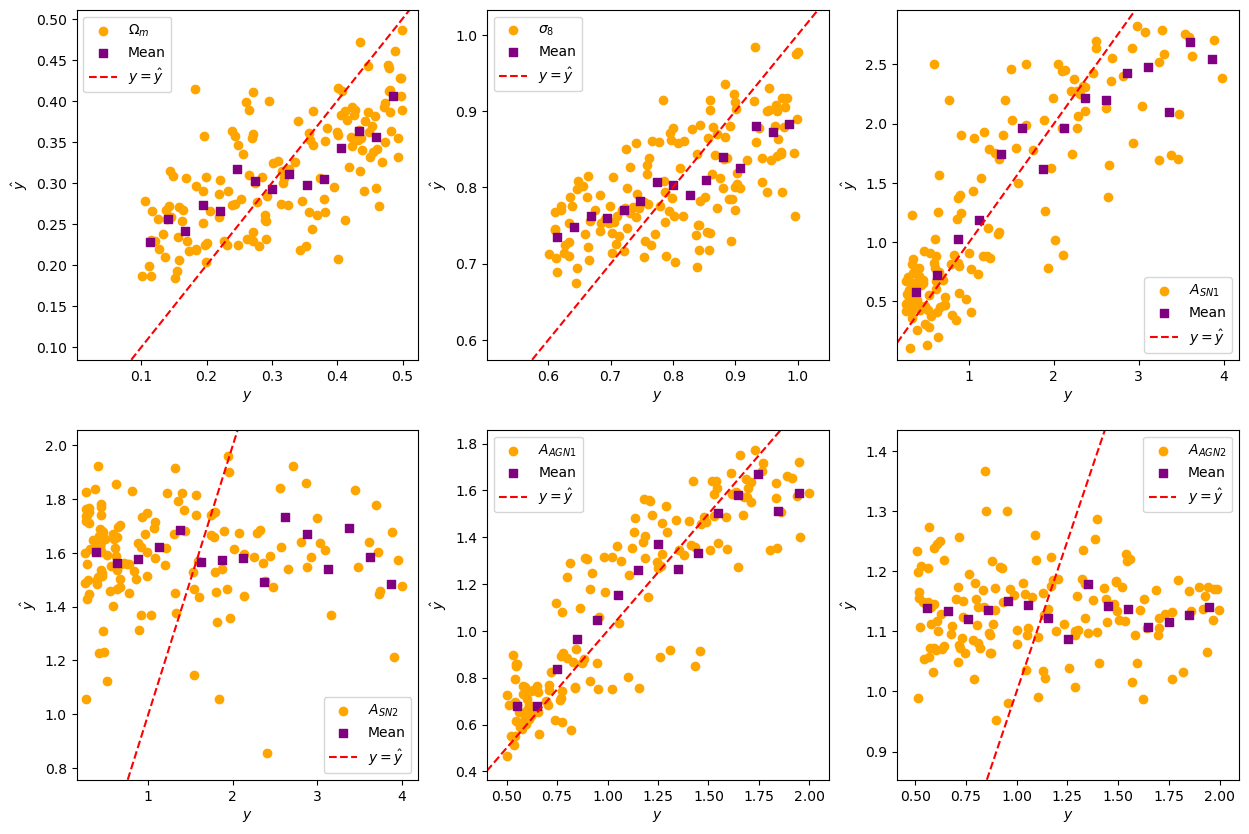

In [207]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
labels = ['$\Omega_m$', '$\sigma_8$', '$A_{SN1}$', '$A_{SN2}$', '$A_{AGN1}$', '$A_{AGN2}$']

for i in range(y_true.shape[1]):
    ax[i//3, i%3].scatter(Y[:, i], Yhat[:, i], label = labels[i], color = 'orange')
    mean, bin_edges_x, binnumber = stats.binned_statistic(Y[:, i], Yhat[:, i], statistic = np.mean, bins = 15)
    
    ax[i//3, i%3].scatter(bin_edges_x[:-1]+0.5*np.diff(bin_edges_x), mean, label = 'Mean', marker = 's', color = 'purple')
    ax[i//3, i%3].axline((0, 0), slope = 1, color = 'r', linestyle = '--', label = "$y=\hat{y}$")
    
    ax[i//3, i%3].set_xlabel('$y$')
    ax[i//3, i%3].set_ylabel('$\hat{y}$')
    ax[i//3, i%3].set_xlim(left = (Y[:, i].min()-0.1))
    ax[i//3, i%3].set_ylim(bottom = (Yhat[:, i].min()-0.1))
    ax[i//3, i%3].legend()

plt.show()

In effetti, dal punto di vista del valore minimo raggiunto per la validation loss, abbiamo perso precisione. All'atto pratico, questa differenza è minima. Come mai? La risposta è da cercarsi nella dimensione dei dataset in uso: se un dataset è sufficientemente grande, media, deviazione standard, valore minimo e valore massimo del set di training dovrebbero essere pressoché coincidenti con gli stessi indici del dataset completo. Questo rende le operazioni di normalizzazione e standardizzazione estremamente simili nei due casi.

### 7. Conclusioni

Possiamo quindi trarre le seguenti conclusioni:
* abbiamo addestrato una rete neurale fully connected, ottimizzandone gli iperparametri;
* abbiamo mostrato che questa è in grado di <b>approssimare</b> la funzione inversa che mappa la SFRD nei parametri cercati;
* la rete ha raggiunto buone performance sui parametri $\Omega_m$, $\sigma_8$, $A_{SN1}$ e $A_{AGN1}$;
* i parametri $A_{SN2}$ e $A_{AGN2}$ sono stati predetti meno bene;
* un dataset di 1000 simulazioni potrebbe essere relativamente piccolo per ottenere alte precisioni in un compito del genere;
* la funzione inversa non è perfettamente definita in quanto sono presenti degenerazioni.

Un possibile miglioramento potrebbe essere l'introduzione di un approccio ad ensamble, dove si allenino $N$ modelli con la stessa architettura ma con condizioni iniziali differenti, imponendo le stime

\begin{align*}
    \hat{\theta} = \frac{1}{N}\sum_i \hat{\theta}_i\\
    \sigma^2_{\hat{\theta}} = \frac{1}{N-1}\sum_i(\hat{\theta_i}-\hat{\theta})^2
\end{align*}

Un altro miglioramento potrebbe essere quello di considerare più osservabili fisiche indipendenti che dipendano dai parametri in modi diversi: più osservabili abbiamo a disposizione, meno è probabile che due set diversi di parametri producano la stessa coppia di osservabili (più invertibilità corrisponde a meno degenerazione).

Complessivamente, il progetto dimostra che la SFRD contiene un'informazione significativa sui parametri cosmologici ed astrofisici (anche se non sembra essere completamente invertibile) e che le reti neurali possano apprendere tale una mappatura inversa efficace. Nonostante le limitazioni, il risultato è promettente e rappresenta un passo verso un uso più sistematico del machine learning per l'inferenza di parametri cosmologici ed astrofisici da simulazioni idrodinamiche.